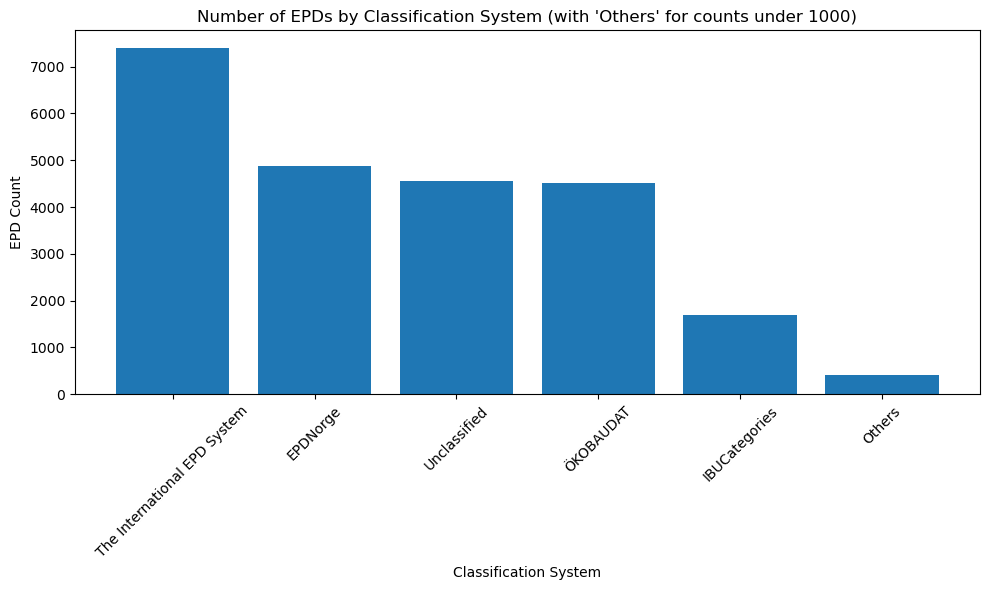

,classification_system,epd_count
0,The International EPD System,7406
1,EPDNorge,4872
2,Unclassified,4551
3,ÖKOBAUDAT,4520
4,IBUCategories,1693
5,Others,411


In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# 1. Connect to the database
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# 2. SQL query:
#    - Use COALESCE to include entries without a classification system by substituting 'no explicit classification'
#    - Convert classification_system values to lowercase for a case-insensitive grouping
#    - Order the results by epd_count in descending order
query = """
    SELECT 
        COALESCE(lower(m.classification_system), 'no explicit classification') AS classification_system,
        COUNT(*) AS epd_count
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    GROUP BY COALESCE(lower(m.classification_system), 'no explicit classification')
    ORDER BY epd_count DESC
"""

cursor.execute(query)
rows = cursor.fetchall()

# 3. Load the results into a pandas DataFrame
df = pd.DataFrame(rows, columns=["classification_system", "epd_count"])

# Always close the connection when done
conn.close()

# 4. Rename the classification systems according to your mapping
mapping = {
    "the international epd system": "The International EPD System",
    "epdnorge": "EPDNorge",
    "no explicit classification": "Unclassified",
    "oekobau.dat": "ÖKOBAUDAT",
    "ibucategories": "IBUCategories"
}
df["classification_system"] = df["classification_system"].replace(mapping)

# 5. Partition the DataFrame into large groups (>= 1000) and small groups (< 1000)
df_large = df[df["epd_count"] >= 1000].copy()
df_small = df[df["epd_count"] < 1000].copy()

# Sum the counts of the small groups and label them "Others"
others_count = df_small["epd_count"].sum()
if others_count > 0:
    df_others = pd.DataFrame([{"classification_system": "Others", "epd_count": others_count}])
    df_final = pd.concat([df_large, df_others], ignore_index=True)
else:
    df_final = df_large.copy()

# 6. Sort the final DataFrame by epd_count in descending order
df_final = df_final.sort_values(by="epd_count", ascending=False)

# 7. Create a bar plot with the classification systems ordered from left (highest count) to right (lowest count)
plt.figure(figsize=(10,6))
plt.bar(df_final["classification_system"], df_final["epd_count"])
plt.title("Number of EPDs by Classification System (with 'Others' for counts under 1000)")
plt.xlabel("Classification System")
plt.ylabel("EPD Count")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()       # Adjust layout to ensure everything fits well
plt.show()

# Display the final DataFrame to verify the data
df_final


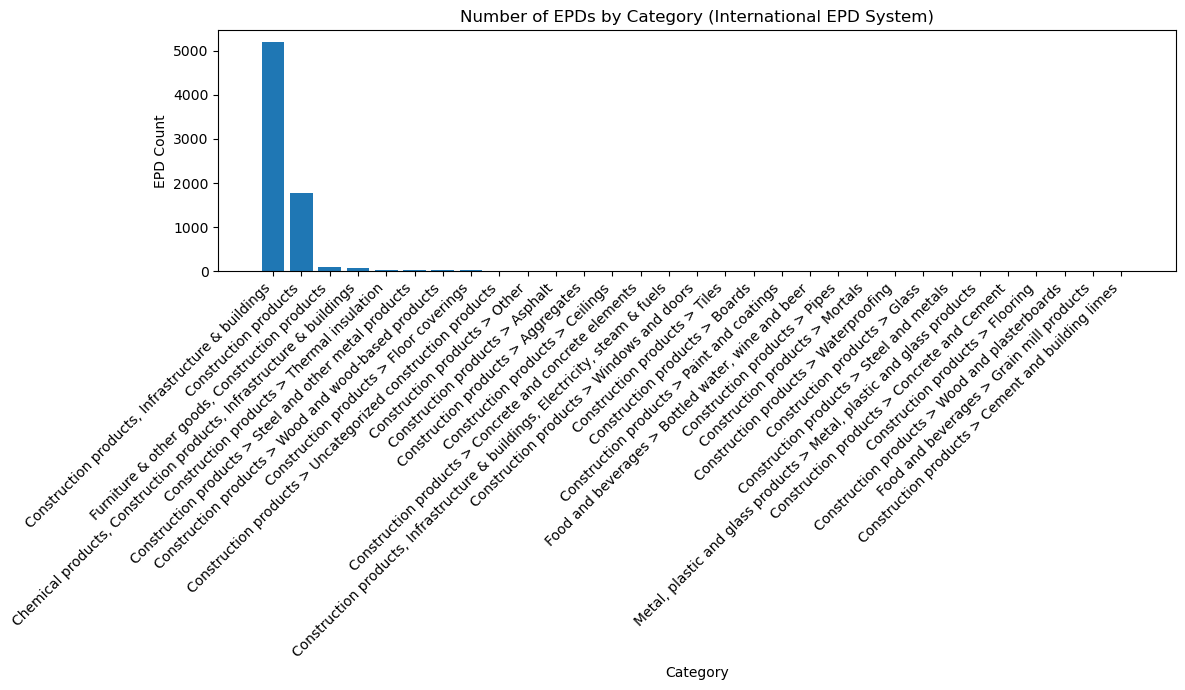

,category,epd_count,percentage
0,"Construction products, Infrastructure & buildings",5199,70.21
1,Construction products,1769,23.89
6,"Furniture & other goods, Construction products",108,1.46
20,"Chemical products, Construction products, Infr...",68,0.92
7,Construction products > Thermal insulation,42,0.57
3,Construction products > Steel and other metal ...,32,0.43
12,Construction products > Wood and wood-based pr...,26,0.35
5,Construction products > Floor coverings,22,0.30
4,Construction products > Uncategorized construc...,21,0.28
11,Construction products > Other,21,0.28


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# 1. Connect to the database and fetch documents for "the international epd system"
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

query = """
    SELECT d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    WHERE lower(m.classification_system) = 'the international epd system'
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# 2. Process each document to extract the category from the JSON path:
#    processInformation.dataSetInformation.classificationInformation.classification[0].class
#    If there are multiple levels, join them with " > "
category_counts = defaultdict(int)

for (doc_str,) in rows:
    try:
        doc = json.loads(doc_str)
    except Exception:
        continue  # Skip invalid JSON documents

    try:
        # Navigate to the classification list
        classes = doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"]
    except Exception:
        continue  # Skip documents missing the expected JSON structure

    try:
        # Sort by level and join multiple category levels with " > "
        classes_sorted = sorted(classes, key=lambda x: x.get("level", 0))
        cat_values = [c.get("value", "").strip() for c in classes_sorted if c.get("value", "").strip()]
        if not cat_values:
            continue
        category = " > ".join(cat_values)
        category_counts[category] += 1
    except Exception:
        continue

# 3. Create a DataFrame from the aggregated counts and sort by epd_count descending
df = pd.DataFrame(list(category_counts.items()), columns=["category", "epd_count"])
df = df.sort_values(by="epd_count", ascending=False)

# 4. Add a percentage column showing each category's share relative to the total
total = df["epd_count"].sum()
df["percentage"] = (df["epd_count"] / total) * 100
df["percentage"] = df["percentage"].round(2)

# 5. Plot the results in a bar chart (categories ordered left to right by highest count)
plt.figure(figsize=(12, 7))
plt.bar(df["category"], df["epd_count"])
plt.title("Number of EPDs by Category (International EPD System)")
plt.xlabel("Category")
plt.ylabel("EPD Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Display the DataFrame to verify the data along with the percentage column
df


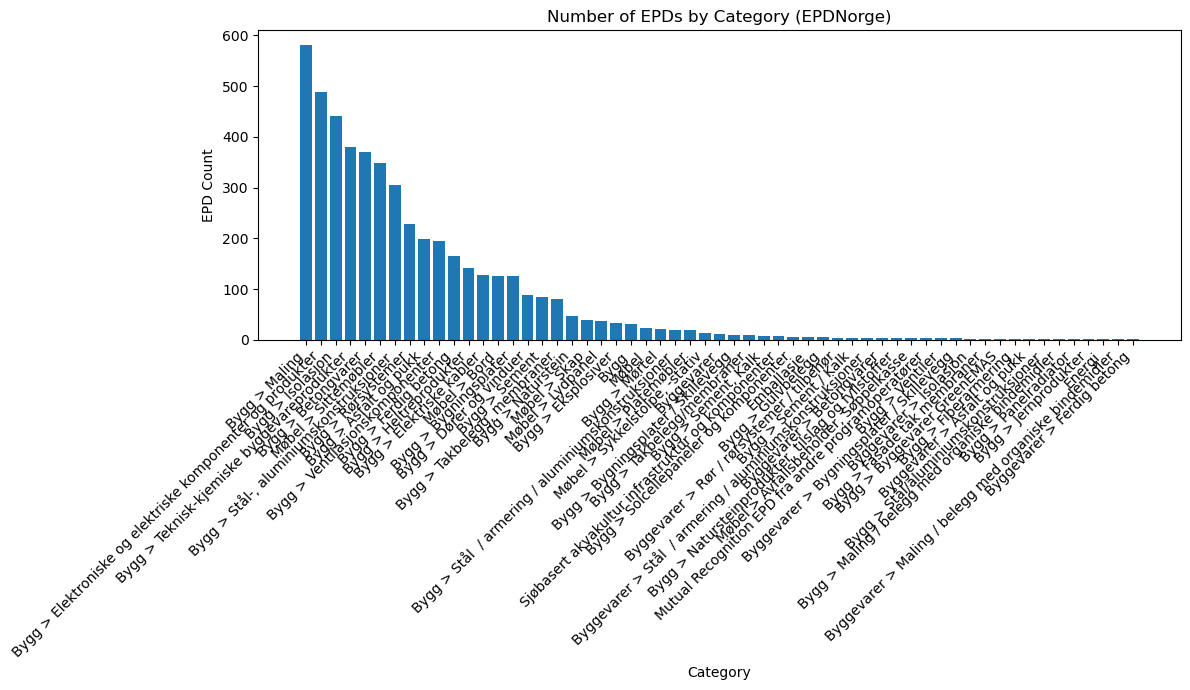

,category,epd_count,percentage
13,Bygg > Maling,581,11.93
8,Bygg > Elektroniske og elektriske komponenter ...,489,10.04
4,Bygg > Isolasjon,441,9.05
6,Bygg > Teknisk-kjemiske byggevareprodukter,381,7.82
1,Bygg > Betongvarer,370,7.59
14,Møbel > Sittemøbler,348,7.14
0,"Bygg > Stål-, aluminiumskonstruksjoner",306,6.28
5,Bygg > Rørsystemer,228,4.68
2,Bygg > Asfalt og pukk,198,4.06
7,Bygg > Ventilasjonskomponenter,195,4.00


In [2]:
# EPDNorge Categories

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# 1. Connect to the database and fetch documents for "epdnorge"
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

query = """
    SELECT d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    WHERE lower(m.classification_system) = 'epdnorge'
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# 2. Process each document to extract the category from the JSON path:
#    processInformation.dataSetInformation.classificationInformation.classification[0].class
#    If there are multiple levels, join them with " > "
category_counts = defaultdict(int)

for (doc_str,) in rows:
    try:
        doc = json.loads(doc_str)
    except Exception:
        continue  # Skip invalid JSON documents

    try:
        # Navigate to the classification list
        classes = doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"]
    except Exception:
        continue  # Skip documents missing the expected JSON structure

    try:
        # Sort by level and join multiple category levels with " > "
        classes_sorted = sorted(classes, key=lambda x: x.get("level", 0))
        cat_values = [c.get("value", "").strip() for c in classes_sorted if c.get("value", "").strip()]
        if not cat_values:
            continue
        category = " > ".join(cat_values)
        category_counts[category] += 1
    except Exception:
        continue

# 3. Create a DataFrame from the aggregated counts and sort by epd_count descending
df = pd.DataFrame(list(category_counts.items()), columns=["category", "epd_count"])
df = df.sort_values(by="epd_count", ascending=False)

# 4. Add a percentage column showing each category's share relative to the total
total = df["epd_count"].sum()
df["percentage"] = (df["epd_count"] / total) * 100
df["percentage"] = df["percentage"].round(2)

# 5. Plot the results in a bar chart (categories ordered left to right by highest count)
plt.figure(figsize=(12, 7))
plt.bar(df["category"], df["epd_count"])
plt.title("Number of EPDs by Category (EPDNorge)")
plt.xlabel("Category")
plt.ylabel("EPD Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Display the DataFrame to verify the data along with the percentage column
df


C:\Users\Georgi\AppData\Local\Temp\ipykernel_9132\3809413803.py:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


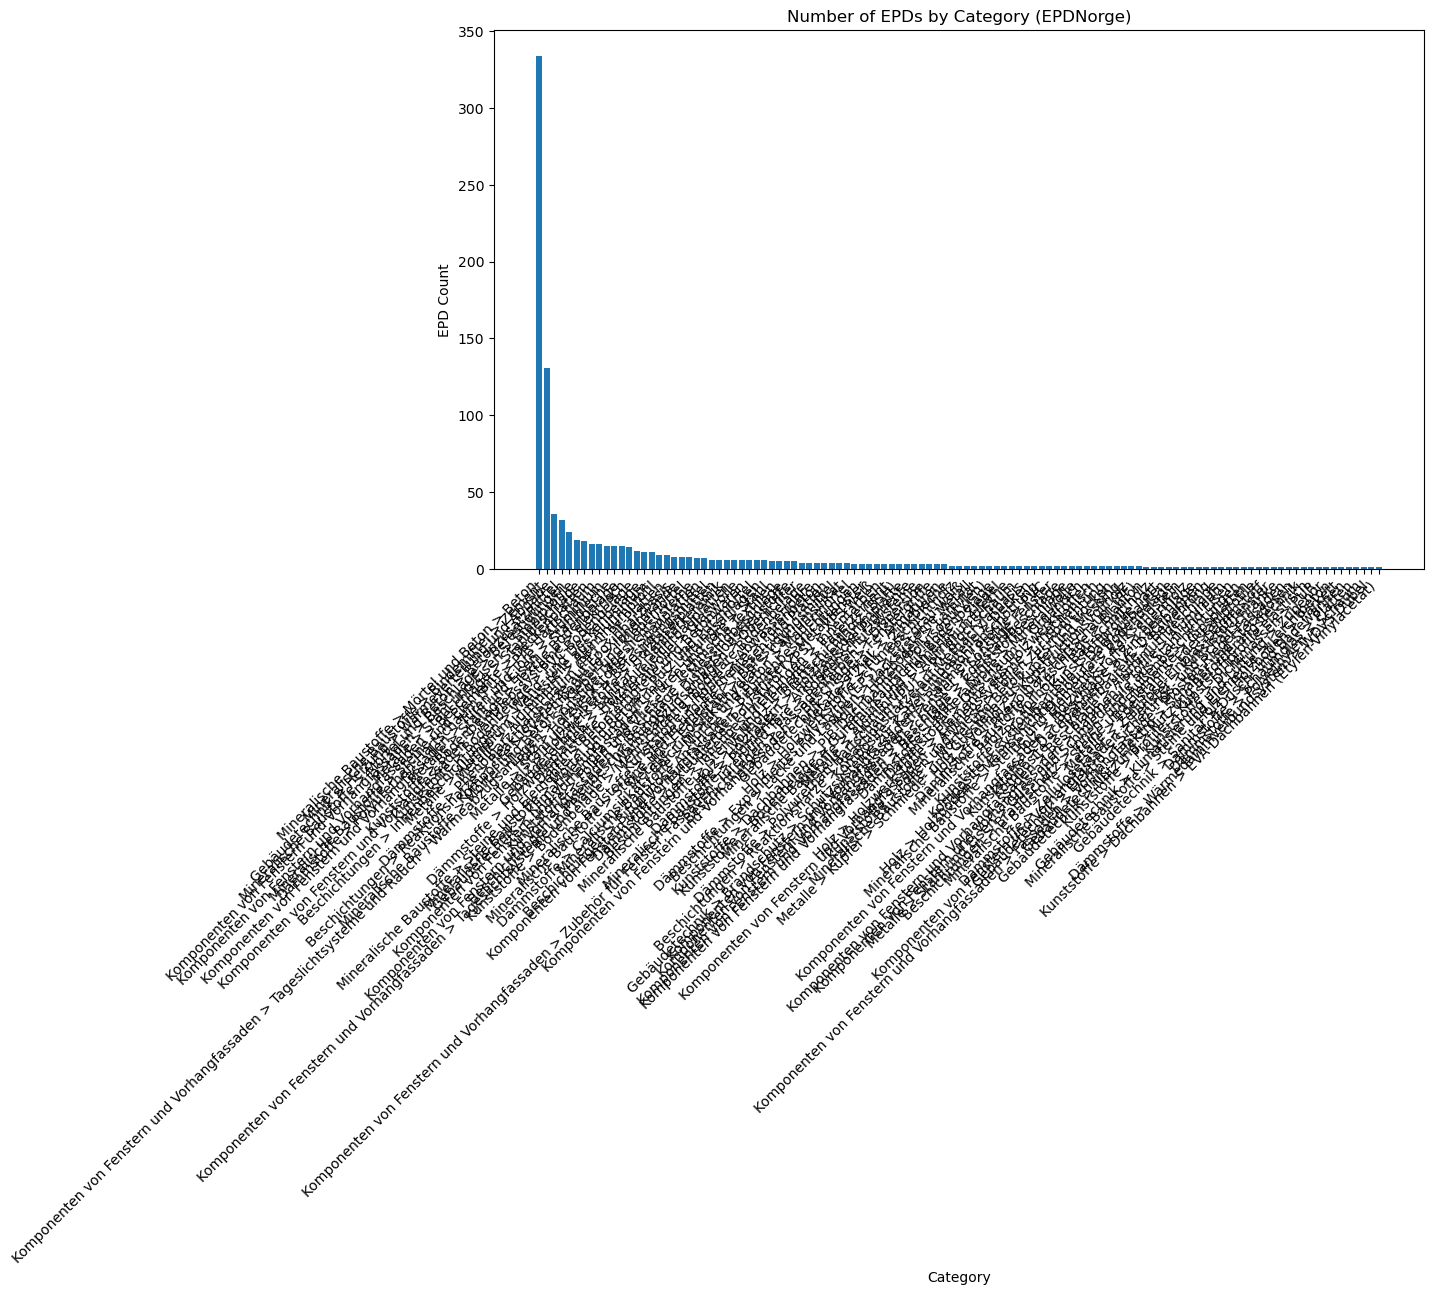

,category,epd_count,percentage
24,Mineralische Baustoffe > Mörtel und Beton > Beton,334,33.60
32,Mineralische Baustoffe > Bindemittel > Zement,131,13.18
55,Gebäudetechnik > Heizung > Wärmeverteilung und...,36,3.62
35,Mineralische Baustoffe > Mörtel und Beton > Be...,32,3.22
23,Komponenten von Fenstern und Vorhangfassaden >...,24,2.41
...,...,...,...
79,Gebäudetechnik > Sanitär > Dusch- und Badewannen,1,0.10
80,Dämmstoffe > Schaumglas > Platten,1,0.10
47,Dämmstoffe > Polyethylen > Schaum,1,0.10
27,Dämmstoffe > Wärmedämmverbundsystem > WDVS-Dübel,1,0.10


In [4]:
# EPDNorge Categories

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# 1. Connect to the database and fetch documents for "epdnorge"
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

query = """
    SELECT d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    WHERE lower(m.classification_system) = 'ibucategories'
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# 2. Process each document to extract the category from the JSON path:
#    processInformation.dataSetInformation.classificationInformation.classification[0].class
#    If there are multiple levels, join them with " > "
category_counts = defaultdict(int)

for (doc_str,) in rows:
    try:
        doc = json.loads(doc_str)
    except Exception:
        continue  # Skip invalid JSON documents

    try:
        # Navigate to the classification list
        classes = doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"]
    except Exception:
        continue  # Skip documents missing the expected JSON structure

    try:
        # Sort by level and join multiple category levels with " > "
        classes_sorted = sorted(classes, key=lambda x: x.get("level", 0))
        cat_values = [c.get("value", "").strip() for c in classes_sorted if c.get("value", "").strip()]
        if not cat_values:
            continue
        category = " > ".join(cat_values)
        category_counts[category] += 1
    except Exception:
        continue

# 3. Create a DataFrame from the aggregated counts and sort by epd_count descending
df = pd.DataFrame(list(category_counts.items()), columns=["category", "epd_count"])
df = df.sort_values(by="epd_count", ascending=False)

# 4. Add a percentage column showing each category's share relative to the total
total = df["epd_count"].sum()
df["percentage"] = (df["epd_count"] / total) * 100
df["percentage"] = df["percentage"].round(2)

# 5. Plot the results in a bar chart (categories ordered left to right by highest count)
plt.figure(figsize=(12, 7))
plt.bar(df["category"], df["epd_count"])
plt.title("Number of EPDs by Category (EPDNorge)")
plt.xlabel("Category")
plt.ylabel("EPD Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Display the DataFrame to verify the data along with the percentage column
df


In [3]:
len(df)

57

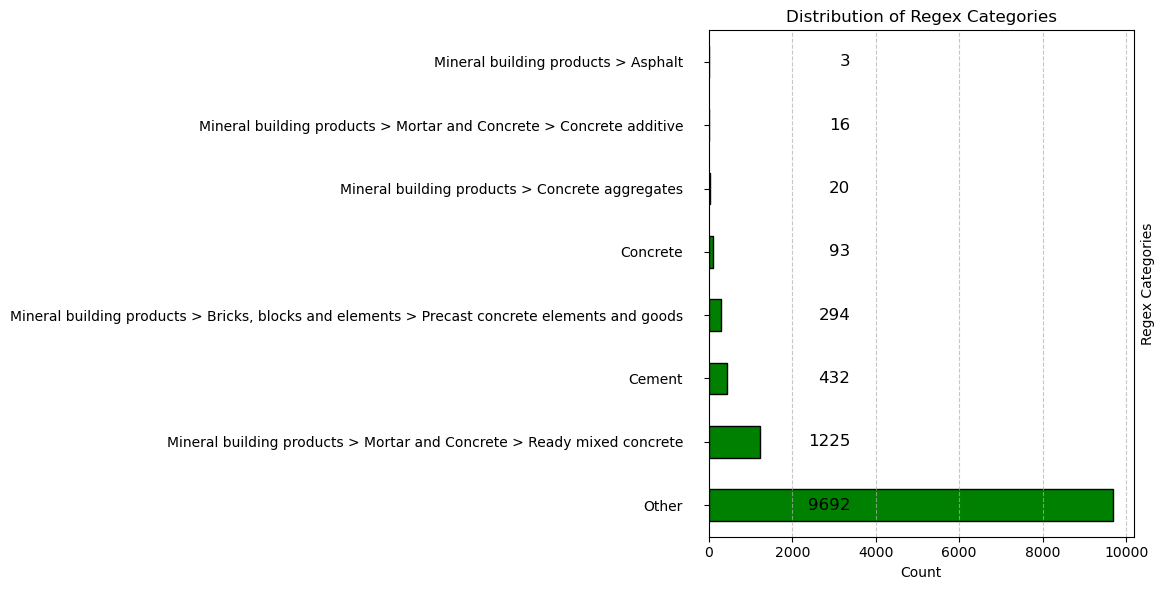

,RegEx Classification,Count
0,Other,9692
1,Mineral building products > Mortar and Concrete > Ready mixed concrete,1225
2,Cement,432
3,"Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods",294
4,Concrete,93
5,Mineral building products > Concrete aggregates,20
6,Mineral building products > Mortar and Concrete > Concrete additive,16
7,Mineral building products > Asphalt,3


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the CSV file path (adjust as needed)
file_path = "../data/pipeline2/sql/regex_classified/filtered_epd_data02_classified_all_05.csv"

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Compute the counts of each regex classification
    classification_counts = df["RegEx Classification"].value_counts()
    
    # Convert the counts to a DataFrame for printing
    df_counts = classification_counts.reset_index()
    df_counts.columns = ['RegEx Classification', 'Count']
    
    # Set display options to avoid truncation and line wrapping
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.width', 1000)
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 6))
    ax = classification_counts.plot(kind="barh", edgecolor="black", color="green")
    
    # Set axis labels and title
    plt.ylabel("Regex Categories")
    plt.xlabel("Count")
    plt.title("Distribution of Regex Categories")
    
    # Move the y-axis label to the right of the plot
    ax.yaxis.set_label_coords(1.05, 0.5)
    
    # Increase padding on the y-axis tick labels if needed
    ax.tick_params(axis="y", pad=15)
    
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    
    # Determine the maximum count for positioning labels
    max_count = classification_counts.max()
    
    # Add count labels to the left of each bar
    for p in ax.patches:
        count = int(p.get_width())
        # Position the label to the left of the bar (using 35% of max_count as offset)
        label_x = p.get_x() + 0.35 * max_count
        label_y = p.get_y() + p.get_height() / 2
        ax.text(label_x, label_y, str(count),
                horizontalalignment='right', verticalalignment='center',
                color='black', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Print the DataFrame
df_counts

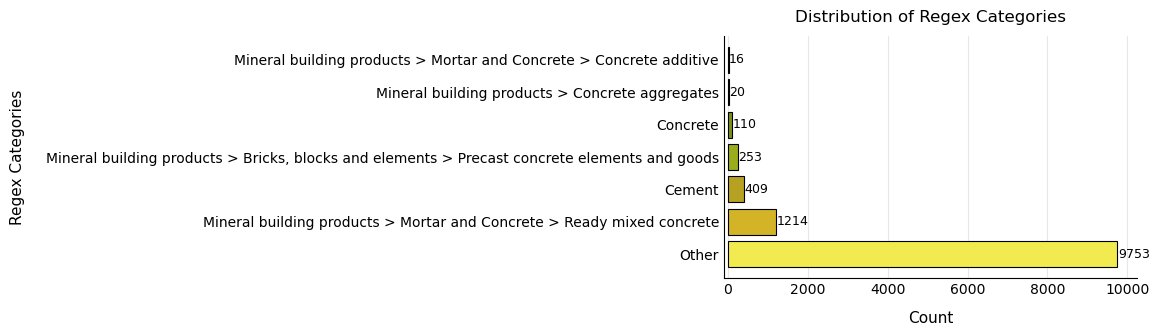

                                                                            RegEx Classification  Count
0                                                                                          Other   9753
1                         Mineral building products > Mortar and Concrete > Ready mixed concrete   1214
2                                                                                         Cement    409
3  Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods    253
4                                                                                       Concrete    110
5                                                Mineral building products > Concrete aggregates     20
6                            Mineral building products > Mortar and Concrete > Concrete additive     16


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the CSV file path (adjust as needed)
file_path = "../data/pipeline2/sql/regex_classified/filtered_epd_data02_classified_all_03.csv"

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Compute the counts of each regex classification
    classification_counts = df["RegEx Classification"].value_counts()

    # Convert the counts to a DataFrame for printing
    df_counts = classification_counts.reset_index()
    df_counts.columns = ['RegEx Classification', 'Count']

    # Set display options to avoid truncation and line wrapping
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.width', 1000)

    # Color palette (same as in Plot 2)
    colors = [
        "#F1EB4F",
        "#D3B427",
        "#B6A123",
        "#9BAD1C",
        "#7B9216",
        "#5C7610",
        "#3E580B",
        "#253904",
        "#161F03",
        "#141C03",
        "#121902",
    ]

    # Figure dimensions (same approach as Plot 2)
    fig_width = 29.42 / 2.54  # ~12.56 inches
    fig_height = 8.79 / 2.54  # ~3.46 inches
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Create a horizontal bar chart
    # We'll cycle through the colors for each bar.
    y_positions = range(len(classification_counts))
    bars = ax.barh(
        y_positions,
        classification_counts.values,
        edgecolor="black",
        linewidth=0.8,
        color=[
            colors[i % len(colors)] for i in range(len(classification_counts))
        ],
    )

    # Set y-ticks and labels to match the categories
    ax.set_yticks(y_positions)
    ax.set_yticklabels(classification_counts.index)

    # Axis labels and title
    ax.set_xlabel("Count", fontsize=11, labelpad=10)
    ax.set_ylabel("Regex Categories", fontsize=11, labelpad=15)
    ax.set_title("Distribution of Regex Categories", fontsize=12, pad=10)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Remove tick marks for a cleaner look
    ax.tick_params(axis="both", which="both", length=0)

    # Adjust y-axis to create more space at the bottom
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin - 0.01 * (xmax - xmin), xmax)

    # Annotate each bar with its count
    for rect in bars:
        width = rect.get_width()
        y = rect.get_y() + rect.get_height() / 2
        ax.text(
            width + 10,  # small offset to the right of each bar
            y,
            f"{int(width)}",
            ha="left",
            va="center",
            fontsize=9
        )

    # Adjust margins, show plot
    plt.tight_layout()
    plt.show()

    # Print the DataFrame
    print(df_counts)


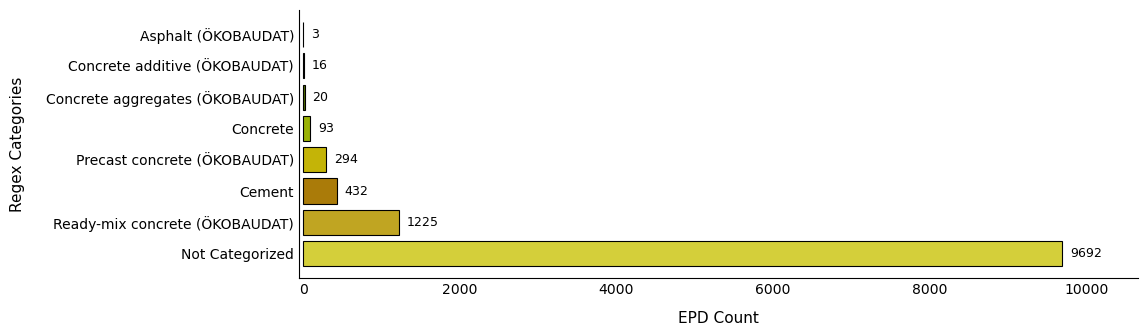

                                RegEx Classification  Count  \
0                                              Other   9692   
1  Mineral building products > Mortar and Concret...   1225   
2                                             Cement    432   
3  Mineral building products > Bricks, blocks and...    294   
4                                           Concrete     93   
5    Mineral building products > Concrete aggregates     20   
6  Mineral building products > Mortar and Concret...     16   
7                Mineral building products > Asphalt      3   

                        Short Name  
0                  Not Categorized  
1   Ready-mix concrete (ÖKOBAUDAT)  
2                           Cement  
3     Precast concrete (ÖKOBAUDAT)  
4                         Concrete  
5  Concrete aggregates (ÖKOBAUDAT)  
6    Concrete additive (ÖKOBAUDAT)  
7              Asphalt (ÖKOBAUDAT)  


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the CSV file path (adjust as needed)
file_path = "../data/pipeline2/sql/regex_classified/filtered_epd_data02_classified_all_05.csv"

# 1. Define a mapping from full classification to short name
short_name_mapping = {
    "Other": "Not Categorized",
    "Mineral building products > Mortar and Concrete > Ready mixed concrete": "Ready-mix concrete (ÖKOBAUDAT)",
    "Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods": "Precast concrete (ÖKOBAUDAT)",
    "Mineral building products > Concrete aggregates": "Concrete aggregates (ÖKOBAUDAT)",
    "Mineral building products > Mortar and Concrete > Concrete additive": "Concrete additive (ÖKOBAUDAT)",
    "Mineral building products > Asphalt": "Asphalt (ÖKOBAUDAT)",
    "Cement": "Cement",
    "Concrete": "Concrete",
    # Add other mappings as needed
}


# 3. Read the CSV file
df = pd.read_csv(file_path)

# 4. Compute the counts of each regex classification
classification_counts = df["RegEx Classification"].value_counts()

# 5. Convert to a DataFrame to hold classification and counts
classification_counts_df = classification_counts.reset_index()
classification_counts_df.columns = ["RegEx Classification", "Count"]

# 6. Map full classification to short names
classification_counts_df["Short Name"] = classification_counts_df["RegEx Classification"].apply(
    lambda x: short_name_mapping.get(x, x)  # fallback to original if not in dict
)

# 7. Sort if you want descending by count (optional)
classification_counts_df = classification_counts_df.sort_values("Count", ascending=False).reset_index(drop=True)

# 8. Set up a color palette (same as your Plot 2)
colors = [
    "#F1EB4F",
    "#D3B427",
    "#B6A123",
    "#9BAD1C",
    "#7B9216",
    "#5C7610",
    "#3E580B",
    "#253904",
    "#161F03",
    "#141C03",
    "#121902",
]

# 8. Set up a color palette (same as your Plot 2)
colors = [
    "#d4cf3a",
    "#c0a522",
    "#aa7b09",
    "#c4b407",
    "#9ab206",
    "#526f03",
    "#385902",
    "#3b4a05",
    "#3e3e08",
    "#50501e",
    "#121902",
]

# # 8. Set up a color palette (same as your Plot 2)
# colors = [
# "#00441B",  # dark forest green
# "#2A9D8F",  # teal
# "#8CB369",  # moss green
# "#F4A261",  # earth orange
# "#E9C46A",  # sand yellow
# "#264653",  # deep blue‑green
# "#BC4749",  # brick red
# "#6A994E",  # olive green
# "#577590",  # desaturated blue
# "#FFB5A7",  # soft coral
# "#3D405B",  # slate blue
# "#81B29A",  # sage green
# ]

    # # 8. Set up a color palette (same as your Plot 2)
# colors = [
"#D4CF3A",  # vivid chartreuse (kept)
"#C9A326",  # richer gold (tweaked)
"#F1A208",  # vibrant amber (replaces muddy brown)
"#BFD833",  # lime/moss (tweaked)
"#7FB800",  # bright green (tweaked from 9ab206)
"#2E7D32",  # lively dark green (lightened 526f03)
"#00441B",  # forest green (accent)
"#2A9D8F",  # teal accent
"#E9C46A",  # sand yellow accent
"#BC4749",  # brick red accent
"#577590",  # blue accent
"#81B29A",  # sage accent
# ]

# 9. Figure dimensions to match Plot 2
fig_width = 29.42 / 2.54  # ~12.56 inches
fig_height = 8.79 / 2.54  # ~3.46 inches
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# 10. Plot a horizontal bar chart using the short names
y_positions = range(len(classification_counts_df))
bars = ax.barh(
    y_positions,
    classification_counts_df["Count"].values,
    edgecolor="black",
    linewidth=0.8,
    color=[colors[i % len(colors)] for i in range(len(classification_counts_df))]
)

# 11. Set the y-axis ticks and labels to the "Short Name"
ax.set_yticks(y_positions)
ax.set_yticklabels(classification_counts_df["Short Name"])

# 12. Axis labels, title, and styling
ax.set_xlabel("EPD Count", fontsize=11, labelpad=10)
ax.set_ylabel("Regex Categories", fontsize=11, labelpad=15)
ax.set_title("", fontsize=12, pad=10)

# Remove top/right spines and disable tick lines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="both", which="both", length=0)

# 13. Annotate each bar with its count
max_count = classification_counts_df["Count"].max()

# Increase the x-axis maximum so there's space for annotations
ax.set_xlim(0, max_count * 1.1)  # 10% extra space on the right

for rect in bars:
    width = rect.get_width()
    y_center = rect.get_y() + rect.get_height() / 2
    
    # Use an offset that's some fraction of the max count
    offset = max_count * 0.01
    
    ax.text(
        width + offset,  # move 1% of max_count to the right
        y_center,
        f"{int(width)}",
        ha="left",
        va="center",
        fontsize=9,
        clip_on=False      # ensures text isn’t clipped by the axes
    )

# Adjust x-axis to create more space on the side
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin - 0.005 * (xmax - xmin), xmax)


# 14. Adjust layout, display plot
plt.tight_layout()
plt.show()

# 15. (Optional) print the shorter name table
print(classification_counts_df)


In [64]:
classification_counts_df

,RegEx Classification,Count,Short Name
0,Other,9692,Not Categorized
1,Mineral building products > Mortar and Concret...,1225,Ready-mix concrete (ÖKOBAUDAT)
2,Cement,432,Cement
3,"Mineral building products > Bricks, blocks and...",294,Precast concrete (ÖKOBAUDAT)
4,Concrete,93,Concrete
5,Mineral building products > Concrete aggregates,20,Concrete aggregates (ÖKOBAUDAT)
6,Mineral building products > Mortar and Concret...,16,Concrete additive (ÖKOBAUDAT)
7,Mineral building products > Asphalt,3,Asphalt (ÖKOBAUDAT)


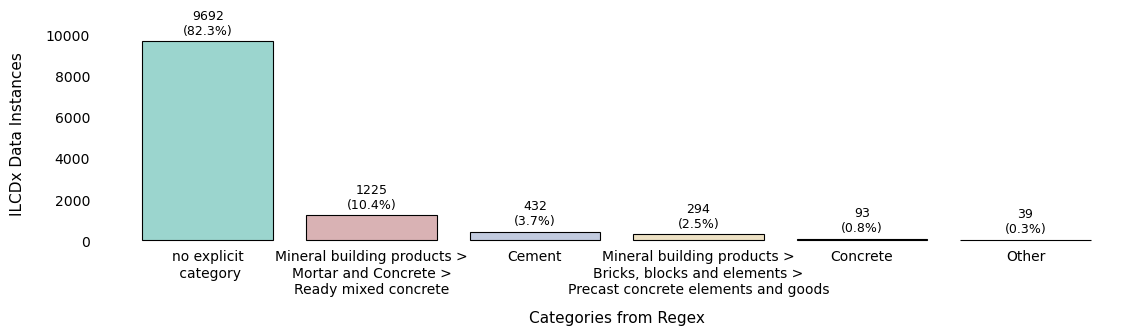

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data
file_path = "../data/pipeline2/sql/regex_classified/filtered_epd_data02_classified_all_05.csv"
df = pd.read_csv(file_path)

# 2. Count each RegEx classification
counts = df["RegEx Classification"].value_counts()
df_counts = counts.reset_index()
df_counts.columns = ["Category", "Count"]

# 2a. Rename the original “Other” to “no explicit category”
df_counts["Category"] = df_counts["Category"] \
    .replace({"Other": "no explicit\n category"})

# 3. Group small counts (<90) into “Other”
threshold = 90
major = df_counts[df_counts["Count"] >= threshold].copy()
minor = df_counts[df_counts["Count"] <  threshold].copy()
other_count = minor["Count"].sum()

df_plot = pd.concat([
    major,
    pd.DataFrame([{"Category": "Other", "Count": other_count}])
], ignore_index=True) \
  .sort_values("Count", ascending=False) \
  .reset_index(drop=True)

# 4. Compute percentages
total = df_plot["Count"].sum()
df_plot["Percent"] = df_plot["Count"] / total * 100

# 5. Build multiline labels
def multiline(label):
    if label in ("Other", "no explicit category"):
        return label
    return " >\n".join(label.split(" > "))

df_plot["Label"] = df_plot["Category"].apply(multiline)

# 6. Prepare colors and figure
# colors = [
#     "#F1EB4F","#D3B427","#B6A123","#9BAD1C",
#     "#7B9216","#5C7610","#3E580B","#253904",
#     "#161F03","#141C03","#121902",
# ]

# Color-blind palette for thesis
colors = [
    "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    "#D9B2B4",  # dusty rose (Concrete class)
    "#C2CBDF",  # lavender‐purple (Classification system)
    "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    "#BCCFB1",  # pale sage (BKI element)
    "#C2FADB",  # light jade (Material category concept)
    "#F1D6C1",  # peach sand (Canonical category)

]


fig_w = 29.42 / 2.54  # ~12.56"
fig_h =  8.79 / 2.54  # ~3.46"
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# 7. Plot vertical bars at explicit x positions
x = list(range(len(df_plot)))
bars = ax.bar(
    x,
    df_plot["Count"],
    color=[colors[i % len(colors)] for i in x],
    edgecolor="black",
    linewidth=0.8
)

# 8. Give 10% headroom so annotations aren’t clipped
max_count = df_plot["Count"].max()
ax.set_ylim(0, max_count * 1.1)

# 9. Set xticks & labels (no rotation)
ax.set_xticks(x)
ax.set_xticklabels(df_plot["Label"], rotation=0, ha="center")

# 10. Axis labels
ax.set_xlabel("Categories from Regex", fontsize=11, labelpad=10)
ax.set_ylabel("ILCDx Data Instances", fontsize=11, labelpad=15)

# 11. Clean up spines & ticks
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis="both", which="both", length=0)

# 12. Adjust y-axis to create a bit more bottom space
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# 13. Annotate each bar: count then percentage
offset = max_count * 0.02
for i, bar in enumerate(bars):
    h   = bar.get_height()
    pct = df_plot.loc[i, "Percent"]
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + offset,
        f"{int(h)}\n({pct:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=9,
        clip_on=False
    )

# 14. Make room for multiline labels
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.savefig("data/img/4.3_cat_regex.pdf", format="pdf", bbox_inches="tight")
plt.show()


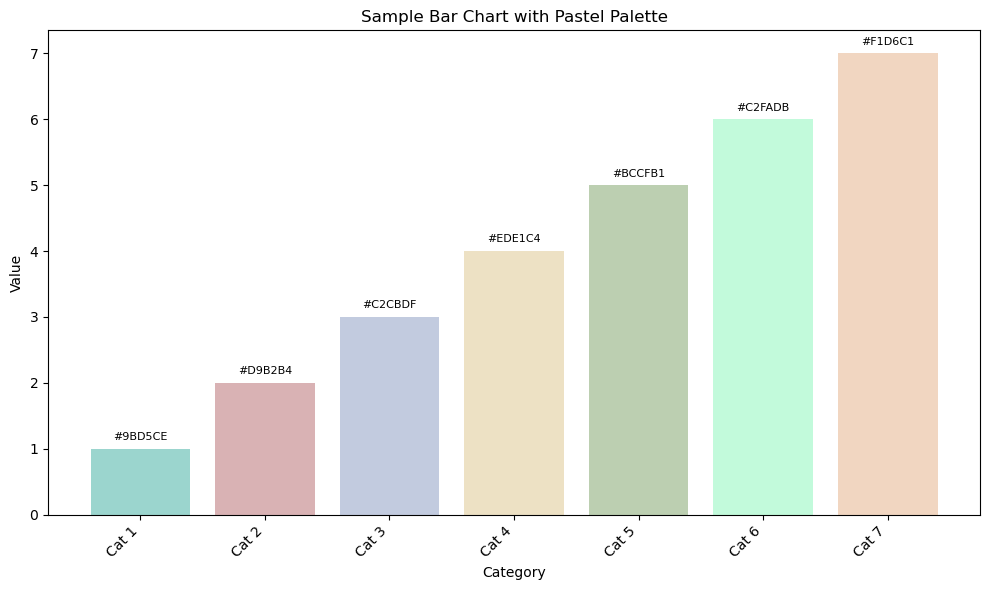

In [24]:
import matplotlib.pyplot as plt

# Pastel palette defined earlier
pastel = [
    "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    "#D9B2B4",  # dusty rose (Concrete class)
    "#C2CBDF",  # lavender‐purple (Classification system)
    "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    "#BCCFB1",  # pale sage (BKI element)
    "#C2FADB",  # light jade (Material category concept)
    "#F1D6C1",  # peach sand (Canonical category)
]

# Sample data
categories = [f"Cat {i+1}" for i in range(len(pastel))]
values = [i + 1 for i in range(len(pastel))]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=pastel)
plt.xticks(rotation=45, ha='right')
plt.title("Sample Bar Chart with Pastel Palette")
plt.ylabel("Value")
plt.xlabel("Category")

# Annotate each bar with its color hex code
for bar, color in zip(bars, pastel):
    y_val = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y_val + 0.1, color, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [63]:
print(df_plot.drop(columns="Label").to_string(index=False))

                                                                                     Category  Count   Percent
                                                                       no explicit\n category   9692 82.309979
                       Mineral building products > Mortar and Concrete > Ready mixed concrete   1225 10.403397
                                                                                       Cement    432  3.668790
Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods    294  2.496815
                                                                                     Concrete     93  0.789809
                                                                                        Other     39  0.331210


In [25]:
import sqlite3
import pandas as pd
import json

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# Connect to the database and fetch each document's classification_system and JSON
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

query = """
    SELECT 
        COALESCE(lower(m.classification_system), 'no explicit classification') AS classification_system,
        d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# Define accepted broad category terms (all lower case)
broad_terms = {"construction products, infrastructure & buildings", "construction products"}

# Process each row to determine its category type: "Broad Category", "Missing", or "Adequate"
records = []
for raw_cs, doc_str in rows:
    cs = raw_cs  # classification system from the metadata (already lowercased)
    cat_type = "Missing"  # default assumption
    try:
        doc = json.loads(doc_str)
    except Exception:
        doc = {}

    try:
        classes = doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"]
        # Try to get the level 0 value
        candidate = None
        for item in classes:
            if item.get("level", None) == 0:
                candidate = item
                break
        if candidate is None and classes:
            candidate = classes[0]
        if candidate:
            val = candidate.get("value", "").strip()
            if not val:
                cat_type = "Missing"
            elif val.lower() in broad_terms:
                cat_type = "Broad Category"
            else:
                cat_type = "Adequate"
        else:
            cat_type = "Missing"
    except Exception:
        cat_type = "Missing"
    
    records.append({
        "classification_system": cs,
        "cat_type": cat_type
    })

# Create and cache the DataFrame with raw processed records
df_raw = pd.DataFrame(records)

# Optionally display the first few rows to verify the output
# df_raw.head()

# Optionally, save the DataFrame to a CSV file to avoid reprocessing in the future:
# df_raw.to_csv("processed_epd_data.csv", index=False)


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the renaming mapping for the classification system
rename_mapping = {
    "the international epd system": "The International EPD System",
    "epdnorge": "EPDNorge",
    "no explicit classification": "Unclassified",
    "oekobau.dat": "ÖKOBAUDAT",
    "ibucategories": "IBUCategories"
}
df_raw["classification_system"] = df_raw["classification_system"].replace(rename_mapping)

# 1. Aggregate counts by classification_system and cat_type
agg_df = df_raw.groupby(["classification_system", "cat_type"]) \
               .size() \
               .reset_index(name="epd_count")

# 2. Calculate total document count per classification system
totals = df_raw.groupby("classification_system") \
               .size() \
               .reset_index(name="total_count")

# Merge totals with the aggregated data and relabel systems with < 1000 as "Others"
agg_df = agg_df.merge(totals, on="classification_system", how="left")
low_systems = totals[totals["total_count"] < 1000]["classification_system"].tolist()
agg_df.loc[agg_df["classification_system"].isin(low_systems), "classification_system"] = "Others"

# 3. Re-aggregate after relabeling
final_df = agg_df.groupby(["classification_system", "cat_type"])["epd_count"] \
                 .sum() \
                 .reset_index()

# 4. Pivot the data for a stacked bar chart
pivot_df = final_df.pivot(index="classification_system", columns="cat_type", values="epd_count") \
                   .fillna(0)
pivot_df["Total"] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values("Total", ascending=False)
pivot_df = pivot_df.drop(columns="Total")

# 1. Define the custom color mapping using the provided colors. (presentation)
color_dict = {
    "Broad Category": "#9BD5CE",  # chosen from your palette
    "Missing":         "#D9B2B4",  # chosen from your palette
    "Adequate":        "white"     # chosen from your palette
}

# 1. Define the custom color mapping using the provided colors. (thesis)
color_dict = {
    "Broad Category": "#9BD5CE",  # chosen from your palette
    "Missing":         "#D9B2B4",  # chosen from your palette
    "Adequate":        "white"     # chosen from your palette
}

    # "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    # "#D9B2B4",  # dusty rose (Concrete class)
    # "#C2CBDF",  # lavender‐purple (Classification system)
    # "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    # "#BCCFB1",  # pale sage (BKI element)
    # "#C2FADB",  # light jade (Material category concept)
    # "#F1D6C1",  # peach sand (Canonical category)

# 2. Ensure pivot_df has the desired columns and order.
desired_order = ["Broad Category", "Missing", "Adequate"]
for col in desired_order:
    if col not in pivot_df.columns:
        pivot_df[col] = 0
pivot_df = pivot_df[desired_order]

# 3. Update the classification system label for two-line formatting.
pivot_df.rename(
    index={"The International EPD System": "The International\nEPD System"},
    inplace=True
)

# 4. Set the figure dimensions in inches (31.9 cm × 9.69 cm → inches).
fig_width = 29.42 / 2.54  # ~12.56 inches
fig_height = 8.79 / 2.54  # ~3.46 inches

# 5. Create the stacked bar chart.
ax = pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(fig_width, fig_height),
    color=[color_dict[col] for col in desired_order],
    linewidth=0.8,
    edgecolor="black"
)

# 8. Annotate each stacked bar with total count and percent of overall.
totals = pivot_df.sum(axis=1)
grand_total = totals.sum()
for i, total in enumerate(totals):
    pct = total / grand_total * 100
    offset = totals.max() * 0.02
    ax.text(
        i,
        total + offset,
        f"{int(total)}\n({pct:.0f}%)",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Compute category-level percentages for the legend
category_totals = pivot_df.sum(axis=0)
grand_total_all = category_totals.sum()
b_pct = category_totals["Broad Category"] / grand_total_all * 100
m_pct = category_totals["Missing"]         / grand_total_all * 100
a_pct = category_totals["Adequate"]        / grand_total_all * 100

# Create custom legend handles with percentage in labels
broad_handle = mpatches.Patch(
    facecolor=color_dict["Broad Category"],
    edgecolor="black",
    linewidth=0.5,
    label=f"Broad ({b_pct:.0f}%)"
)
missing_handle = mpatches.Patch(
    facecolor=color_dict["Missing"],
    edgecolor="black",
    linewidth=0.5,
    label=f"Missing ({m_pct:.0f}%)"
)
adequate_handle = mpatches.Patch(
    facecolor="none",
    edgecolor="black",
    linewidth=0.5,
    label=f"Adequate ({a_pct:.0f}%)"
)

# Update the legend without a border
plt.legend(
    handles=[broad_handle, missing_handle, adequate_handle],
    title="Material Category",
    frameon=False
)

# 9. Additional formatting.
ax.set_xlabel("Classification System", fontsize=11, labelpad=10)
ax.set_ylabel("ILCDx Data Instances",     fontsize=11, labelpad=15)
ax.tick_params(axis='both', which='both', length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

# Adjust bottom margin
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# Custom Y-ticks: 0, 1000, then every 2000 from 3000 upward
ymax = ax.get_ylim()[1]
custom_ticks = [0, 1000] + list(range(3000, int(ymax) + 1, 2000))
ax.set_yticks(custom_ticks)

# Optional: grid behind bars
# ax.set_axisbelow(True)
# plt.grid(axis="y", linestyle="-", alpha=0.3)

plt.xticks(rotation=0, ha="center", fontsize=10)
plt.tight_layout()
plt.savefig("data/img/4.1_count_ILCDx_instances.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Optionally display the pivoted DataFrame
pivot_df


NameError: name 'df_raw' is not defined

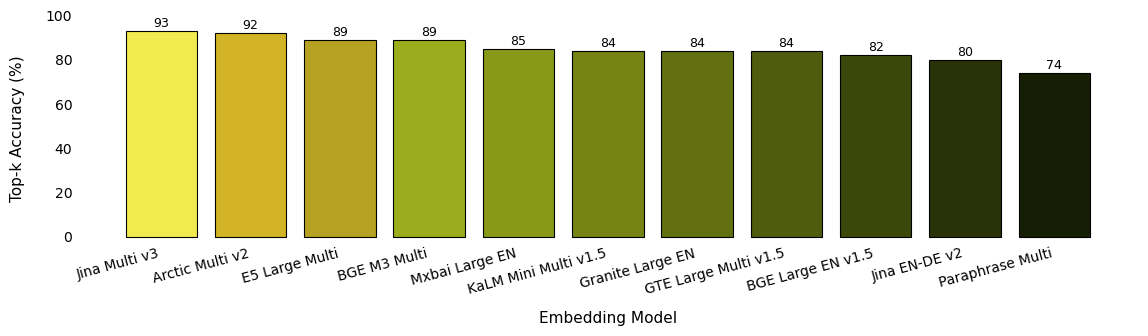

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Read data from the CSV file
csv_path = "../data/pipeline2/md/summary_table_embed_eval_res_20250408_150331.csv"
df = pd.read_csv(csv_path)

# 2. Create shorter names for the models
short_names = {
    "jinaai/jina-embeddings-v3": "Jina Multi v3",
    "snowflake-arctic-embed2:latest": "Arctic Multi v2",
    "jeffh/intfloat-multilingual-e5-large-instruct:f32": "E5 Large Multi",
    "bge-m3:latest": "BGE M3 Multi",
    "mxbai-embed-large:latest": "Mxbai Large EN",
    "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5": "KaLM Mini Multi v1.5",
    "granite-embedding:278m": "Granite Large EN",
    "Alibaba-NLP/gte-large-en-v1.5": "GTE Large Multi v1.5",
    "bge-large:latest": "BGE Large EN v1.5",
    "jina/jina-embeddings-v2-base-de:latest": "Jina EN-DE v2",
    "paraphrase-multilingual:latest": "Paraphrase Multi",
}
# short_names = {
#     "jinaai/jina-embeddings-v3": "jina-embeddings-v3",
#     "snowflake-arctic-embed2:latest": "snowflake-arctic-embed2",
#     "jeffh/intfloat-multilingual-e5-large-instruct:f32": "intfloat-multilingual-e5-large-instruct",
#     "bge-m3:latest": "bge-m3",
#     "mxbai-embed-large:latest": "mxbai-embed-large",
#     "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5": "KaLM-embedding-multilingual-mini-instruct-v1.5",
#     "granite-embedding:278m": "granite-embedding-278m",
#     "Alibaba-NLP/gte-large-en-v1.5": "gte-large-en-v1.5",
#     "bge-large:latest": "bge-large",
#     "jina/jina-embeddings-v2-base-de:latest": "jina-embeddings-v2-base-de",
#     "paraphrase-multilingual:latest": "paraphrase-multilingual",
# }

df["Short Name"] = df["Embedding Model"].map(short_names)

# 3. Convert the Top-k Accuracy to percentage
df["Top-k Accuracy"] = df["Top-k Accuracy"] * 100

# 4. Sort by Top-k Accuracy descending (optional, for clarity)
df = df.sort_values("Top-k Accuracy", ascending=False).reset_index(drop=True)

# Define the list of colors
colors = [
    "#F1EB4F",
    "#D3B427",
    "#B6A123",
    "#9BAD1C",
    "#889918",
    "#758415",
    "#627011",
    "#4F5C0E",
    "#3C480A",
    "#293307",
    "#161F03",
]

# Color-blind palette for thesis
# colors = [
#     "#00441B",  # dark forest green
#     "#2A9D8F",  # teal
#     "#8CB369",  # moss green
#     "#F4A261",  # earth orange
#     "#E9C46A",  # sand yellow
#     "#264653",  # deep blue‑green
#     "#BC4749",  # brick red
#     "#6A994E",  # olive green
#     "#577590",  # desaturated blue
#     "#FFB5A7",  # soft coral
#     "#3D405B",  # slate blue
#     "#81B29A",  # sage green
# ]

# colors = [
#     "#D4CF3A",  # vivid chartreuse (kept)
#     "#C9A326",  # richer gold (tweaked)
#     "#F1A208",  # vibrant amber (replaces muddy brown)
#     "#BFD833",  # lime/moss (tweaked)
#     "#7FB800",  # bright green (tweaked from 9ab206)
#     "#2E7D32",  # lively dark green (lightened 526f03)
#     "#00441B",  # forest green (accent)
#     "#2A9D8F",  # teal accent
#     "#E9C46A",  # sand yellow accent
#     "#BC4749",  # brick red accent
#     "#577590",  # blue accent
#     "#81B29A",  # sage accent
# ]

# 4. Set up the figure size
fig_width = 29.42 / 2.54  # ~12.56 inches
fig_height = 8.79 / 2.54  # ~3.46 inches
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Prepare x and y
x_labels = df["Short Name"]
y_values = df["Top-k Accuracy"]

# 6. Create bars, cycling through the colors
bars = []
for i, (model, pct) in enumerate(zip(x_labels, y_values)):
    color = colors[i % len(colors)]
    bar = ax.bar(model, pct, color=color, edgecolor="black", linewidth=0.8)
    bars.append(bar)

# 7. Annotate each bar with its Top-k Accuracy (as percentage)
for bar_group in bars:
    for rect in bar_group:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.5,  # small offset above the bar
            f"{int(height)}",  # one decimal place
            ha="center",
            va="bottom",
            fontsize=9,
        )

# Set labels
ax.set_xlabel("Embedding Model", fontsize=11, labelpad=10)
ax.set_ylabel("Top-k Accuracy (%)", fontsize=11, labelpad=15)

# 6. Remove top and right spines for a cleaner look + additional formatting from your snippet
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# We want to see 0 to 100 on y-axis
ax.set_ylim(0, 100)

# Adjust y-axis to create more space at the bottom
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# Rotate x-axis labels a bit if needed for readability
plt.xticks(rotation=15, ha="right")

plt.tight_layout()
plt.show()

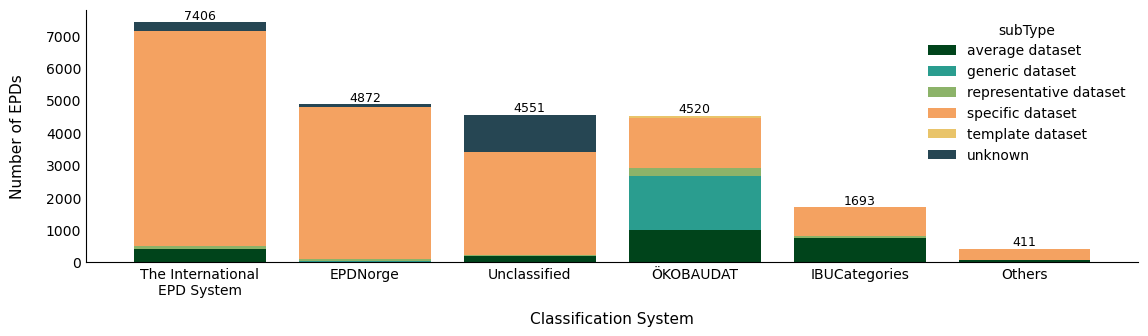

In [1]:
# -*- coding: utf-8 -*-
"""
EPD analysis – notebook‑style edition
====================================
Two Jupyter notebook cells:

* **Cell 1 – Fetch & prepare** → builds a tidy ``pivot`` DataFrame with rows =
  classification systems and columns = subType values.
* **Cell 2 – Visualise** → creates a stacked bar chart with a 12‑colour, nature
  & earth‑toned palette that is colour‑blind safe and offers clear contrast for
  academic print.  The first six hues correspond to the current sub‑types; the
  additional six are available for future categories or other plots.
"""

###############################################################################
# %% [fetch] – Load libraries, query DBs, build pivot table
###############################################################################

import glob
import sqlite3
from pathlib import Path
from typing import List

import pandas as pd

# Configuration ----------------------------------------------------------------
DB_DIR = Path("../data/pipeline2/sql")        # directory containing *.sqlite
DB_PATTERN = str(DB_DIR / "*.sqlite")         # glob pattern
JSON_COL = "document"                         # correct JSON column name

CLASS_MAPPING = {
    "the international epd system": "The International\nEPD System",
    "epdnorge": "EPDNorge",
    "no explicit classification": "Unclassified",
    "oekobau.dat": "ÖKOBAUDAT",
    "ibucategories": "IBUCategories",
}
SMALL_GROUP_THRESHOLD = 1_000

# Helper functions -------------------------------------------------------------

def discover_databases() -> List[str]:
    return glob.glob(DB_PATTERN)


def extract_from_db(db_path: str) -> pd.DataFrame:
    """Return DataFrame with (classification_system, subtype) rows."""
    conn = sqlite3.connect(db_path)
    query = fr"""
        SELECT
            COALESCE(LOWER(m.classification_system), 'no explicit classification')
                AS classification_system,
            json_extract(d.{JSON_COL},
                         '$.modellingAndValidation.LCIMethodAndAllocation.other.anies[0].value')
                AS subtype
        FROM epd_documents AS d
        JOIN epd_metadata  AS m ON d.uuid = m.uuid
    """
    try:
        return pd.read_sql_query(query, conn)
    finally:
        conn.close()

# Main data pipeline -----------------------------------------------------------
_dfs = [extract_from_db(p) for p in discover_databases()]
df_raw = pd.concat(_dfs, ignore_index=True)

df_raw["classification_system"] = df_raw["classification_system"].replace(CLASS_MAPPING)
df_raw["subtype"] = df_raw["subtype"].fillna("unknown")

# Collapse rare classes into "Others"
size_by_class = df_raw.groupby("classification_system").size().reset_index(name="epd_count")
rare_classes = set(size_by_class.loc[size_by_class["epd_count"] < SMALL_GROUP_THRESHOLD,
                                    "classification_system"])

df_raw["classification_system"] = df_raw["classification_system"].apply(
    lambda x: "Others" if x in rare_classes else x
)

# Build stacked‑plot matrix
pivot = (
    df_raw.groupby(["classification_system", "subtype"]).size()
          .unstack(fill_value=0)
)

# Order rows by total size
pivot = pivot.reindex(pivot.sum(axis=1).sort_values(ascending=False).index)

# "pivot" is ready for visualisation

###############################################################################
# %% [viz] – Stacked bar chart
###############################################################################

import matplotlib.pyplot as plt
import numpy as np

# Figure size (converted from cm → inches)
fig_width = 29.42 / 2.54  # ≈12.56 in
fig_height = 8.79 / 2.54  # ≈3.46 in
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Subtype order
subtype_order = [
    "average dataset",
    "generic dataset",
    "representative dataset",
    "specific dataset",
    "template dataset",
    "unknown",
]

# Extended 12‑colour, colour‑blind‑safe palette
# Sources: first six from earlier nature palette; next six chosen from
# ColorBrewer & Okabe‑Ito inspired hues for complementary contrast.
extended_palette = [
    "#00441B",  # dark forest green
    "#2A9D8F",  # teal
    "#8CB369",  # moss green
    "#F4A261",  # earth orange
    "#E9C46A",  # sand yellow
    "#264653",  # deep blue‑green
    "#BC4749",  # brick red
    "#6A994E",  # olive green
    "#577590",  # desaturated blue
    "#FFB5A7",  # soft coral
    "#3D405B",  # slate blue
    "#81B29A",  # sage green
]

# #  Tweaked original 12‑colour palette
# extended_palette = [
#     "#D4CF3A",  # vivid chartreuse (kept)
#     "#C9A326",  # richer gold (tweaked)
#     "#F1A208",  # vibrant amber (replaces muddy brown)
#     "#BFD833",  # lime/moss (tweaked)
#     "#7FB800",  # bright green (tweaked from 9ab206)
#     "#2E7D32",  # lively dark green (lightened 526f03)
#     "#00441B",  # forest green (accent)
#     "#2A9D8F",  # teal accent
#     "#E9C46A",  # sand yellow accent
#     "#BC4749",  # brick red accent
#     "#577590",  # blue accent
#     "#81B29A",  # sage accent
# ]

colour_map = {st: extended_palette[i] for i, st in enumerate(subtype_order)}

# Ensure all expected columns exist, even if empty
for st in subtype_order:
    if st not in pivot.columns:
        pivot[st] = 0

# Plot each subType layer with consistent colours
bottom = np.zeros(len(pivot))
for subtype in subtype_order:
    values = pivot[subtype].values
    ax.bar(
        pivot.index,
        values,
        bottom=bottom,
        color=colour_map[subtype],
        # edgecolor="black",
        # linewidth=0.8,
        label=subtype,
    )
    bottom += values

# Annotate totals above each bar
for x_pos, total in enumerate(bottom):
    ax.text(
        x_pos,
        total + 0.5,
        f"{int(total)}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Axis labels and styling
ax.set_xlabel("Classification System", fontsize=11, labelpad=10)
ax.set_ylabel("Number of EPDs", fontsize=11, labelpad=15)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# y‑axis limits for breathing room
ax.set_ylim(0, bottom.max() * 1.05)

plt.xticks(rotation=0, ha="center")

# Legend to the right, outside the plot area
ax.legend(
    title="subType",
    # bbox_to_anchor=(1.02, 1),
    loc="upper right",
    frameon=False,
)

plt.tight_layout()
plt.show()


In [61]:
pivot

subtype,average dataset,generic dataset,representative dataset,specific dataset,template dataset,unknown
classification_system,,,,,,
The International\nEPD System,390,0,119,6628,1,268
EPDNorge,1,39,53,4685,1,93
Unclassified,194,0,12,3199,0,1146
ÖKOBAUDAT,985,1685,227,1554,68,1
IBUCategories,751,0,40,894,8,0
Others,72,1,0,338,0,0


KeyError: 'specific dataset'

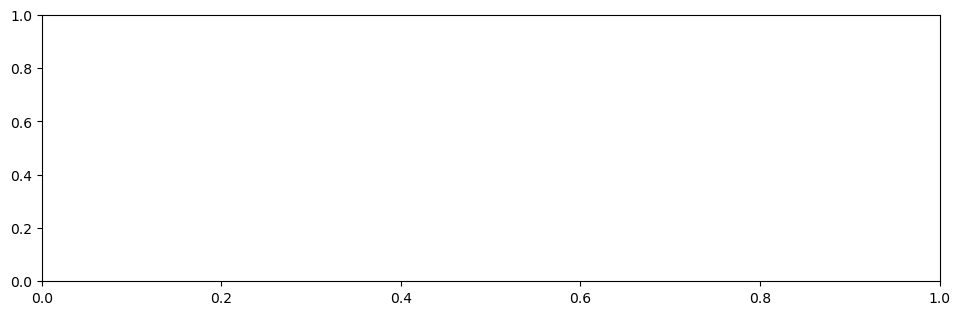

In [43]:
# -*- coding: utf-8 -*-
"""
One‑off bar chart summarising all dataset types (descending order) with percentages
===============================================================================
This cell assumes the `pivot` DataFrame already exists.  It sums across rows to
obtain the total number of EPDs per subType, sorts descending, and visualises
them as a single‑series bar chart.  Counts are annotated above each bar and
a legend at the right shows each subType with its percentage of the total.
"""

import matplotlib.pyplot as plt
import numpy as np

# Ensure prerequisites exist
try:
    pivot
except NameError:
    raise RuntimeError("The 'pivot' DataFrame is not defined. Run the fetch cell first.")
try:
    colour_map
except NameError:
    raise RuntimeError("'colour_map' dict not found. Run the viz cell in the other canvas first.")

# Compute totals, percentages, and sort descending
subtype_order = [
    "average dataset",
    "generic dataset",
    "representative dataset",
    "specific dataset",
    "template dataset",
    "unknown",
]
subtype_totals = (
    pivot.sum(axis=0)
         .loc[subtype_order]
         .sort_values(ascending=False)
)
counts = subtype_totals.values
percentages = 100 * counts / counts.sum()
labels = subtype_totals.index

# Plot setup
fig_width = 29.42 / 2.54  # ≈12.56 in
fig_height = 8.79 / 2.54  # ≈3.46 in
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Bars
bars = ax.bar(
    labels,
    counts,
    color=[colour_map[lab] for lab in labels],
    edgecolor="black",
    linewidth=0.8,
)

# Annotate counts above bars
for rect in bars:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 0.5,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Legend with percentages
legend_labels = [f"{lab} ({pct:.1f}%)" for lab, pct in zip(labels, percentages)]
ax.legend(
    bars,
    legend_labels,
    title="Dataset Type",
    # bbox_to_anchor=(1.02, 1),
    loc="upper right",
    frameon=False,
)

# Styling
ax.set_xlabel("Dataset Type", fontsize=11, labelpad=10)
ax.set_ylabel("Number of EPDs", fontsize=11, labelpad=15)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(0, counts.max() * 1.05)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)
plt.xticks(rotation=0, ha="center")
plt.tight_layout()
plt.show()


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from collections import defaultdict

# Define path to EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# Fetch documents classified under the International EPD System
conn = sqlite3.connect(DB_PATH)
query = """
    SELECT d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    WHERE lower(m.classification_system) = 'the international epd system'
"""
rows = conn.execute(query).fetchall()
conn.close()

# Count categories (JSON path: processInformation...classification[0].class)
raw_counts = defaultdict(int)
for (doc_str,) in rows:
    try:
        doc = json.loads(doc_str)
        classes = (doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"])
        # sort levels and extract values
        classes_sorted = sorted(classes, key=lambda x: x.get("level", 0))
        vals = [c.get("value", "").strip() for c in classes_sorted if c.get("value", "").strip()]
        if vals:
            category = " > ".join(vals)
            raw_counts[category] += 1
    except Exception:
        continue

# Threshold small categories into 'Other'
THRESHOLD = 200
other_total = sum(cnt for cnt in raw_counts.values() if cnt < THRESHOLD)
counts = {cat: cnt for cat, cnt in raw_counts.items() if cnt >= THRESHOLD}
if other_total:
    counts['Other'] = other_total

# Build DataFrame and compute percentages
df = pd.DataFrame(list(counts.items()), columns=["category", "epd_count"])
total = df['epd_count'].sum()
df['percentage'] = (df['epd_count'] / total * 100).round(2)
df = df.sort_values(by='epd_count', ascending=False).reset_index(drop=True)


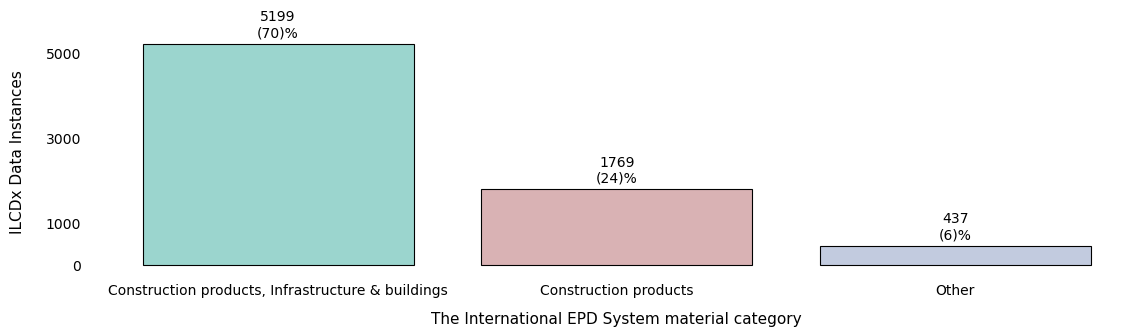

                                            category  epd_count  percentage
0  Construction products, Infrastructure & buildings       5199       70.21
1                              Construction products       1769       23.89
2                                              Other        437        5.90


In [2]:
# Prepare colour map
categories = df["category"].tolist()
#  Tweaked original 12‑colour palette (presentation)
# extended_palette = [
#     "#D4CF3A",  # vivid chartreuse (kept)
#     "#C9A326",  # richer gold (tweaked)
#     "#F1A208",  # vibrant amber (replaces muddy brown)
#     "#BFD833",  # lime/moss (tweaked)
#     "#7FB800",  # bright green (tweaked from 9ab206)
#     "#2E7D32",  # lively dark green (lightened 526f03)
#     "#00441B",  # forest green (accent)
#     "#2A9D8F",  # teal accent
#     "#E9C46A",  # sand yellow accent
#     "#BC4749",  # brick red accent
#     "#577590",  # blue accent
#     "#81B29A",  # sage accent
# ]

# Color-blind palette for thesis
# extended_palette = [
#     "#00441B",  # dark forest green
#     "#2A9D8F",  # teal
#     "#8CB369",  # moss green
#     "#F4A261",  # earth orange
#     "#E9C46A",  # sand yellow
#     "#264653",  # deep blue‑green
#     "#BC4749",  # brick red
#     "#6A994E",  # olive green
#     "#577590",  # desaturated blue
#     "#FFB5A7",  # soft coral
#     "#3D405B",  # slate blue
#     "#81B29A",  # sage green
# ]
# Color-blind palette for thesis
extended_palette = [
    "#9BD5CE",  # pastel aqua (ILCD ProcessDataSet)
    "#D9B2B4",  # dusty rose (Concrete class)
    "#C2CBDF",  # lavender‐purple (Classification system)
    "#EDE1C4",  # muted flax (DIN 276 cost‐group)
    "#BCCFB1",  # pale sage (BKI element)
    "#C2FADB",  # light jade (Material category concept)
    "#F1D6C1",  # peach sand (Canonical category)
]

colour_map = {st: extended_palette[i] for i, st in enumerate(categories)}

# Plot
fig_width = 29.42 / 2.54  # ≈12.56 in
fig_height = 8.79 / 2.54  # ≈3.46 in
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

bars = ax.bar(
    df["category"],
    df["epd_count"],
    color=[colour_map[cat] for cat in df["category"]],
    edgecolor="black",
    linewidth=0.8,
)

# Annotate counts
for rect in bars:
    h = rect.get_height()
    pct = h / total * 100
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        h + df['epd_count'].max() * 0.02,  # vertical offset above the bar
        f"{int(h)}\n({pct:.0f})%",  # two lines: count then percent
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Styling
ax.set_xlabel(
    "The International EPD System material category", fontsize=11, labelpad=10
)
ax.set_ylabel("ILCDx Data Instances", fontsize=11, labelpad=15)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis="x", pad=10)
ax.tick_params(axis="y", pad=10)
ax.set_ylim(0, df["epd_count"].max() * 1.05)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# Custom Y-ticks: 0, 1000, then every 2000 from 3000 upward
ymax = ax.get_ylim()[1]
custom_ticks = [0, 1000] + list(range(3000, int(ymax) + 1, 2000))
ax.set_yticks(custom_ticks)

plt.xticks(rotation=0, ha="center", fontsize=10)
plt.tight_layout()
plt.savefig("data/img/4.2_ILCD_mat_cat_TIES.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Display results
print(df)

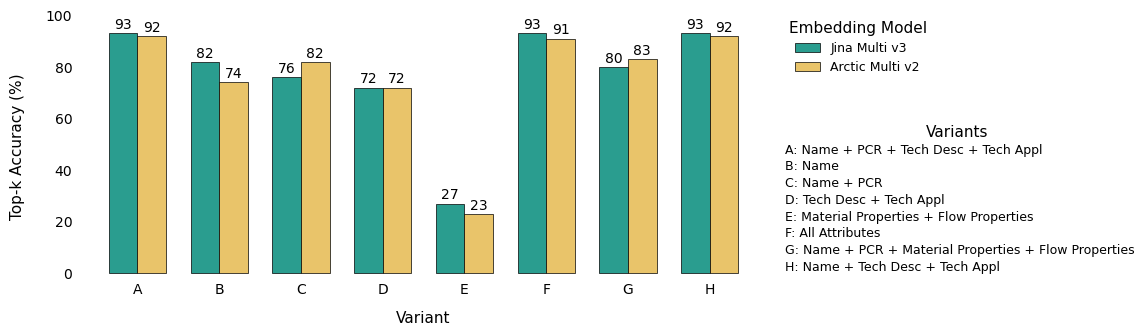

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1. File paths and variant labels
file_paths = [
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_091834.csv",  # A
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_123814.csv",  # B
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_124404.csv",  # C
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_125703.csv",  # D
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_142154.csv",  # E
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_142809.csv",  # F
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_150612.csv",  # G
    "../data/pipeline2/md/summary_table_embed_eval_res_20250430_150906.csv",  # H
]
variants = list("ABCDEFGH")

# 2. Read and assemble Top-k Accuracy (%) for each model×variant
records = []
for path in file_paths:
    df = pd.read_csv(path)
    df["Top-k Accuracy"] = df["Top-k Accuracy"] * 100
    records.append(df.set_index("Embedding Model")["Top-k Accuracy"])
acc_df = pd.DataFrame(records, index=variants)

# 3. Consistent model order and short names
model_order = [
    "jinaai/jina-embeddings-v3",
    "snowflake-arctic-embed2:latest",
]
short_names = {
    "jinaai/jina-embeddings-v3": "Jina Multi v3",
    "snowflake-arctic-embed2:latest": "Arctic Multi v2",
}
acc_df = acc_df[model_order]

# 4. Styling
# colors = ["#D4CF3A", "#C9A326"]
colors = ["#F1EB4F", "#D3B427"] # presentation
colors = ["#2A9D8F", "#E9C46A"] # thesis
fig_width = 29.42 / 2.54  # ~12.56 in
fig_height = 8.79 / 2.54  # ~3.46 in

# 5. Plot bars
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
x = np.arange(len(variants))
bar_width = 0.35

for i, model in enumerate(model_order):
    heights = acc_df[model].values
    bars = ax.bar(
        x + i * bar_width,
        heights,
        width=bar_width,
        color=colors[i],
        edgecolor="black",
        linewidth=0.5,
        label=short_names[model]
    )
    for rect in bars:
        h = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            h + 0.5,
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=10
        )

# 6. Axes styling
ax.set_xlabel("Variant", fontsize=11, labelpad=10)
ax.set_ylabel("Top-k Accuracy (%)", fontsize=11, labelpad=15)
# ax.set_title("Top-k Accuracy per Embedding Model Across Variants", fontsize=12)
ax.set_xticks(x + bar_width * (len(model_order) - 1) / 2)
ax.set_xticklabels(variants, rotation=0)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(0, 100)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# 7. Embedding-model legend – move outside top‐right of the axes
embed_handles, embed_labels = ax.get_legend_handles_labels()
embed_legend = ax.legend(
    embed_handles,
    embed_labels,
    title="Embedding Model",
    loc="upper left",               # anchor legend's upper‐left corner
    bbox_to_anchor=(1.02, 1),      # just outside the axes (x, y) = (1.02, 1.0)
    borderaxespad=0,                 # no extra padding between axes and legend
    fontsize=9,
    title_fontsize=11,
    frameon=False,            # no border
)
ax.add_artist(embed_legend)

# 8. Variant descriptions legend
variant_descriptions = {
    "A": "Name + PCR + Tech Desc + Tech Appl",
    "B": "Name",
    "C": "Name + PCR",
    "D": "Tech Desc + Tech Appl",
    "E": "Material Properties + Flow Properties",
    "F": "All Attributes",
    "G": "Name + PCR + Material Properties + Flow Properties",
    "H": "Name + Tech Desc + Tech Appl",
}
variant_handles = [
    mpatches.Patch(color="none", label=f"{k}: {v}")
    for k, v in variant_descriptions.items()
]
variant_legend = ax.legend(
    handles=variant_handles,
    title="Variants",
    title_fontsize=11,      # smaller title
    fontsize=9,             # smaller labels
    labelspacing=0.3,       # less vertical space
    handlelength=0,         
    handletextpad=0.4,      
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1, 0.3),
    borderpad=0.3,          # padding around the legend box
    columnspacing=0.5,      # spacing between columns if you use ncol>1
    ncol=1,                  # or 2 if you want two narrow columns
)

plt.tight_layout()
plt.savefig("data/img/4.6_top_embed_variants.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [60]:
acc_df = acc_df.astype(int)
acc_df

Embedding Model,jinaai/jina-embeddings-v3,snowflake-arctic-embed2:latest
A,93,92
B,82,74
C,76,82
D,72,72
E,27,23
F,93,91
G,80,83
H,93,92


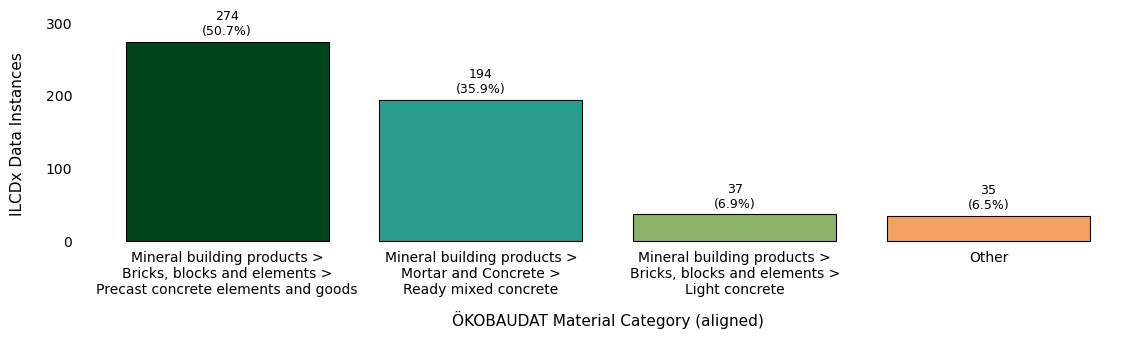

                                                                                     Category  Count   Percent                                                                                           label
Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods    274 50.740741 Mineral building products >\nBricks, blocks and elements >\nPrecast concrete elements and goods
                       Mineral building products > Mortar and Concrete > Ready mixed concrete    194 35.925926                        Mineral building products >\nMortar and Concrete >\nReady mixed concrete
                     Mineral building products > Bricks, blocks and elements > Light concrete     37  6.851852                      Mineral building products >\nBricks, blocks and elements >\nLight concrete
                                                                                        Other     35  6.481481                                                              

In [2]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and extract best_category
categories = []
with open("../data/pipeline2/json/openai/batch_output_EPDNorge_concrete_batch_6816185b6cc08190a28a2829a6c1f780.jsonl", "r") as f:
    for line in f:
        entry = json.loads(line)
        content_str = entry["response"]["body"]["choices"][0]["message"]["content"]
        try:
            content = json.loads(content_str)
            cat = content.get("best_category")
            if cat:
                categories.append(cat)
        except json.JSONDecodeError:
            continue

# 2. Count and pick the top 3 dynamically
counts = Counter(categories)
top3 = [cat for cat, _ in counts.most_common(3)]

# 3. Build filtered counts: keep those top3, lump everything else into "Other"
filtered = {}
other_sum = 0
for cat, cnt in counts.items():
    if cat in top3:
        filtered[cat] = cnt
    else:
        other_sum += cnt
filtered["Other"] = other_sum

# 4. Build DataFrame and sort descending by count
df = pd.DataFrame({
    "Category": list(filtered.keys()),
    "Count": list(filtered.values())
})
df = df.sort_values("Count", ascending=False).reset_index(drop=True)
df["Percent"] = df["Count"] / df["Count"].sum() * 100

# 5. Prepare color palette after sorting
# extended_palette = [
#     "#D4CF3A", "#C9A326", "#F1A208", "#BFD833",
#     "#7FB800", "#2E7D32", "#00441B", "#2A9D8F",
#     "#E9C46A", "#BC4749", "#577590", "#81B29A",
# ]
# Color-blind palette for thesis
extended_palette = [
    "#00441B",  # dark forest green
    "#2A9D8F",  # teal
    "#8CB369",  # moss green
    "#F4A261",  # earth orange
    "#E9C46A",  # sand yellow
    "#264653",  # deep blue‑green
    "#BC4749",  # brick red
    "#6A994E",  # olive green
    "#577590",  # desaturated blue
    "#FFB5A7",  # soft coral
    "#3D405B",  # slate blue
    "#81B29A",  # sage green
]
color_map = {cat: extended_palette[i] for i, cat in enumerate(df["Category"])}

# 6. Multi‐line x‐labels
df["label"] = df["Category"].apply(
    lambda x: x if x == "Other" else x.replace(" > ", " >\n")
)

# 7. Plot
fig_w = 29.42 / 2.54  # cm → inches
fig_h = 8.79 / 2.54
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

bars = ax.bar(
    df["label"],
    df["Count"],
    color=[color_map[cat] for cat in df["Category"]],
    edgecolor="black",
    linewidth=0.8
)

# 8. Annotate each bar: count + percentage above
offset = df["Count"].max() * 0.02
for rect, count, pct in zip(bars, df["Count"], df["Percent"]):
    x = rect.get_x() + rect.get_width() / 2
    h = rect.get_height()
    ax.text(
        x, h + offset,
        f"{int(count)}\n({pct:.1f}%)",
        ha="center", va="bottom",
        fontsize=9, color="black"
    )

# 9. Styling
ax.set_xlabel("ÖKOBAUDAT Material Category (aligned)", fontsize=11, labelpad=10)
ax.set_ylabel("ILCDx Data Instances", fontsize=11, labelpad=15)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(0, df["Count"].max() * 1.1)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

# set y‐ticks every 100 units from 0 up to the maximum
max_val = int(df["Count"].max() * 1.1)
ax.set_yticks(range(0, max_val + 1, 100))

plt.xticks(rotation=0, ha="center")
plt.tight_layout()
plt.savefig("data/img/4.5_ILCD_mat_cat_EPDN.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 10. (Optional) inspect the DataFrame
print(df.to_string(index=False))


In [ ]:
plt.savefig("data/img/epdnorge_plot_540.svg", format="svg", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [6]:
counts

Counter({'Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods': 274,
         'Mineral building products > Mortar and Concrete > Ready mixed concrete': 194,
         'Mineral building products > Bricks, blocks and elements > Light concrete': 37,
         'Mineral building products > Bricks, blocks and elements > Concrete roof tiles': 5,
         'Mineral building products > Bricks, blocks and elements > Substrate': 5,
         'Mineral building products > Mortar and Concrete > Mortar (masonry)': 4,
         'Mineral building products > Bricks, blocks and elements > Ceiling panel': 3,
         'Building service engineering > Electrical > Cable': 2,
         'Mineral building products > Bricks, blocks and elements > Tiles and cladding panels': 2,
         'Plastics > Pipes > Sewer pipes': 2,
         'Mineral building products > Bricks, blocks and elements > Artificial stone': 2,
         'Mineral building products > Mortar and Concrete > Renders

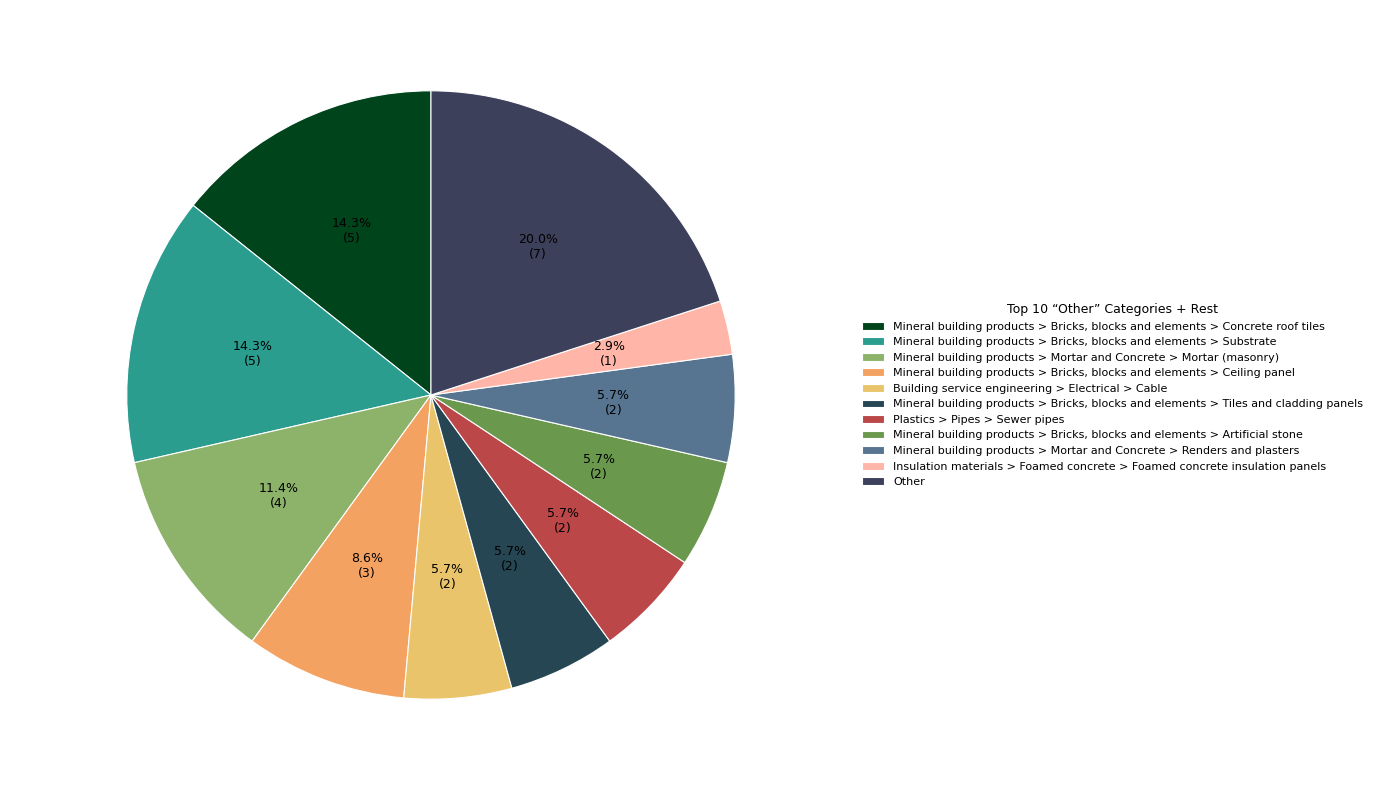

                                                                           Category  Count   Percent
      Mineral building products > Bricks, blocks and elements > Concrete roof tiles      5 14.285714
                Mineral building products > Bricks, blocks and elements > Substrate      5 14.285714
                 Mineral building products > Mortar and Concrete > Mortar (masonry)      4 11.428571
            Mineral building products > Bricks, blocks and elements > Ceiling panel      3  8.571429
                                  Building service engineering > Electrical > Cable      2  5.714286
Mineral building products > Bricks, blocks and elements > Tiles and cladding panels      2  5.714286
                                                     Plastics > Pipes > Sewer pipes      2  5.714286
         Mineral building products > Bricks, blocks and elements > Artificial stone      2  5.714286
             Mineral building products > Mortar and Concrete > Renders and plasters      2 

In [13]:
import json
from collections import Counter
import matplotlib.pyplot as plt

# 1. Load & count best_category
categories = []
with open("../data/pipeline2/json/openai/batch_output_EPDNorge_concrete_batch_6816185b6cc08190a28a2829a6c1f780.jsonl", "r") as f:
    for line in f:
        entry = json.loads(line)
        try:
            content = json.loads(entry["response"]["body"]["choices"][0]["message"]["content"])
            cat = content.get("best_category")
            if cat:
                categories.append(cat)
        except json.JSONDecodeError:
            continue
counts = Counter(categories)

# 2. Exclude the original top-3
top3 = [cat for cat, _ in counts.most_common(3)]
other_items = [(c, cnt) for c, cnt in counts.items() if c not in top3]

# 3. Sort and take the top 10 of “other_items”
other_items.sort(key=lambda x: x[1], reverse=True)
top10 = other_items[:10]
rest_sum = sum(cnt for _, cnt in other_items[10:])

# 4. Prepare labels & sizes
labels = [c for c, _ in top10] + ["Other"]
sizes  = [cnt for _, cnt in top10] + [rest_sum]

# 5. Color palette (enough entries)
# extended_palette = [
#     "#D4CF3A", "#C9A326", "#F1A208", "#BFD833",
#     "#7FB800", "#2E7D32", "#00441B", "#2A9D8F",
#     "#E9C46A", "#BC4749", "#577590", "#81B29A",
# ]
extended_palette = [
    "#00441B",  # dark forest green
    "#2A9D8F",  # teal
    "#8CB369",  # moss green
    "#F4A261",  # earth orange
    "#E9C46A",  # sand yellow
    "#264653",  # deep blue‑green
    "#BC4749",  # brick red
    "#6A994E",  # olive green
    "#577590",  # desaturated blue
    "#FFB5A7",  # soft coral
    "#3D405B",  # slate blue
    "#81B29A",  # sage green
]
colors = extended_palette[:len(labels)]

# 6. Helper for autopct
def make_autopct(vals):
    def inner(pct):
        total = sum(vals)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return inner

# 7. Plot
fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(
    sizes,
    colors=colors,
    startangle=90,
    autopct=make_autopct(sizes),
    wedgeprops=dict(edgecolor="white", linewidth=0.8),
    textprops=dict(color="black", fontsize=9),
    radius=1.1
)
ax.axis("equal")

# 8. Shrink pie to make room for legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])

# 9. Legend
ax.legend(
    wedges,
    labels,
    title="Top 10 “Other” Categories + Rest",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=8,
    title_fontsize=9,
    frameon=False
)

# plt.title("Breakdown of “Other” (Top 10 + Rest)", fontsize=11)
plt.tight_layout()
plt.show()


# Build the DataFrame from your labels & sizes
df_breakdown = pd.DataFrame({
    "Category": labels,
    "Count": sizes
})
df_breakdown["Percent"] = df_breakdown["Count"] / df_breakdown["Count"].sum() * 100

# Print the full table without truncation
print(df_breakdown.to_string(index=False))


In [10]:
import json
import pandas as pd

# 1. Load the JSON file
with open("../data/pipeline2/json/TIES_concrete.json", "r") as f:
    data = json.load(f)

# 2. Filter items where top score exceeds second by > 0.1
matches = []
for item in data:
    cat_scores = item.get("category_score", [])
    if len(cat_scores) >= 2:
        top, second = cat_scores[0], cat_scores[1]
        if top["score"] - second["score"] > 0.1:
            matches.append({
                "UUID": item["UUID"],
                "Top Category": top["category"],
                "Score Difference": top["score"] - second["score"]
            })

# 3. Display results
df_matches = pd.DataFrame(matches)
print(df_matches)


Empty DataFrame
Columns: []
Index: []


In [21]:
import json
import pandas as pd

# Load the JSON file
with open("../data/pipeline2/json/TIES_concrete.json", "r") as f:
    data = json.load(f)

# Collect items with exactly one category_score entry
records = []
for item in data:
    cs = item.get("category_score", [])
    if len(cs) == 1:
        single = cs[0]
        records.append({
            "UUID": item["UUID"],
            "Category": single["category"],
            "Score": single["score"]
        })

# Display via DataFrame
df_single = pd.DataFrame(records)
print(df_single.to_string(index=False))


                                UUID                                                                      Category    Score
ae386399-a291-4bee-37f7-08dc2e3a4f3f      Mineral building products > Bricks, blocks and elements > Light concrete 0.534253
216d330e-ad8a-46f8-3801-08dc2e3a4f3f      Mineral building products > Bricks, blocks and elements > Light concrete 0.509376
63509c59-baa2-44dc-2082-08dad69263c7 Mineral building products > Bricks, blocks and elements > Concrete roof tiles 0.313746
27764740-84c8-46c8-9dee-8301bb72c7f0    Mineral building products > Bricks, blocks and elements > Aerated concrete 0.595893
97ff09e0-1915-41b4-ab26-6680cc3e8163             Mineral building products > Concrete aggregates > Sand and gravel 0.413801
5e41bde3-b154-4ae3-8c96-ff1fcbce0cb5             Mineral building products > Concrete aggregates > Sand and gravel 0.312751
0c2b5146-68b9-4fc3-8dc1-fd6eb2118a25             Mineral building products > Concrete aggregates > Sand and gravel 0.296334
110f4db2

In [ ]:
import json
import pandas as pd

# Load the JSON file
with open("../data/pipeline2/json/EPDNorge_context.json", "r") as f:
    data = json.load(f)

# Collect items with exactly one category_score entry
records = []
for item in data:
    cs = item.get("category_score", [])
    if len(cs) == 1:
        single = cs[0]
        records.append({
            "UUID": item["UUID"],
            "Category": single["category"],
            "Score": single["score"]
        })

# Display via DataFrame
df_single = pd.DataFrame(records)
print(df_single.to_string(index=False))


                                UUID                                                                                      Category    Score
43ed11b1-6776-4a50-b21c-d72a0049029a                        Mineral building products > Mortar and Concrete > Ready mixed concrete 0.406849
59268039-b793-4f31-ac89-05a5cbaefbb3                      Mineral building products > Bricks, blocks and elements > Light concrete 0.394058
a2be3818-98a4-4362-b6b1-6db55d437186                                              Miscellaneous > Transport of goods [t km] > Rail 0.110963
0dda53a5-4e77-4c37-abc6-762db09a67cb                      Mineral building products > Bricks, blocks and elements > Light concrete 0.326918
6cdadd5e-238f-4535-bc2d-4830e2e05bd5                      Mineral building products > Bricks, blocks and elements > Light concrete 0.189937
3342ddb3-7fe8-420a-b89b-2b215d88f6ab                      Mineral building products > Bricks, blocks and elements > Light concrete 0.316432
a3a91d83-8488-4806-b

In [22]:
len(df_single)

13

In [18]:
# for item in data:
#     print(item)
#     if len(data["category_score"]) == 1:
#         print(item)
data

[{'Product': 'Architectural concrete coping',
  'UUID': '963afbd4-3ed1-4105-37fb-08dc2e3a4f3f',
  'Description': 'The declared blocks consist of cement, aggregates mix, and additives. The manufacturing includes mixing the raw materials according to the relevant recipes of the product.',
  'Applicability': 'To be applied internal and external use in all construction sectors.',
  'Flow Property Name': 'Mass',
  'Flow Property Mean Value': 0.8,
  'Flow Property Reference Unit': 'kg',
  'category_score': [{'category': 'Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods',
    'score': 0.38238275051116943},
   {'category': 'Mineral building products > Bricks, blocks and elements > Light concrete',
    'score': 0.3823375701904297},
   {'category': 'Mineral building products > Binder > Cement',
    'score': 0.3734588623046875},
   {'category': 'Mineral building products > Mortar and Concrete > Mortar (masonry)',
    'score': 0.3667336106300354},
   {'

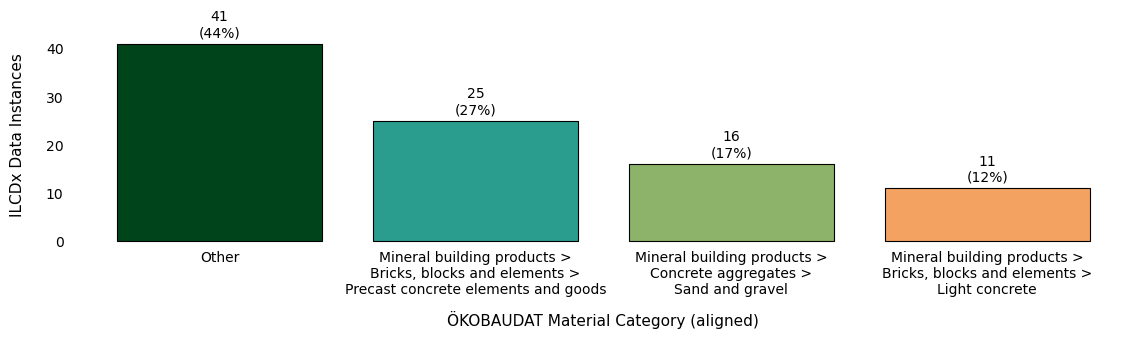

,Category,Count,Percent,label
0,Other,41,44.086022,Other
1,"Mineral building products > Bricks, blocks and...",25,26.881720,"Mineral building products >\nBricks, blocks an..."
2,Mineral building products > Concrete aggregate...,16,17.204301,Mineral building products >\nConcrete aggregat...
3,"Mineral building products > Bricks, blocks and...",11,11.827957,"Mineral building products >\nBricks, blocks an..."


In [3]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and extract best_category
categories = []
with open("../data/pipeline2/json/openai/batch_output_TIES_concrete_batch_6814cdb67bc08190902c4a7f1940df1d.jsonl", "r") as f:
    for line in f:
        entry = json.loads(line)
        content_str = entry["response"]["body"]["choices"][0]["message"]["content"]
        try:
            content = json.loads(content_str)
            cat = content.get("best_category")
            if cat:
                categories.append(cat)
        except json.JSONDecodeError:
            continue

# 2. Count and filter top 3 + Other
counts = Counter(categories)
top_cats = [
    "Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods",
    "Mineral building products > Concrete aggregates > Sand and gravel",
    "Mineral building products > Bricks, blocks and elements > Light concrete",
]
filtered = {}
other_sum = 0
for cat, cnt in counts.items():
    if cat in top_cats:
        filtered[cat] = cnt
    else:
        other_sum += cnt
filtered["Other"] = other_sum

# 3. Build DataFrame and sort descending by count
df = pd.DataFrame({
    "Category": list(filtered.keys()),
    "Count": list(filtered.values())
})
df = df.sort_values("Count", ascending=False).reset_index(drop=True)
df["Percent"] = df["Count"] / df["Count"].sum() * 100

# 4. Prepare palette after sorting
# extended_palette = [
#     "#D4CF3A", "#C9A326", "#F1A208", "#BFD833",
#     "#7FB800", "#2E7D32", "#00441B", "#2A9D8F",
#     "#E9C46A", "#BC4749", "#577590", "#81B29A",
# ]
# Color-blind palette for thesis
extended_palette = [
    "#00441B",  # dark forest green
    "#2A9D8F",  # teal
    "#8CB369",  # moss green
    "#F4A261",  # earth orange
    "#E9C46A",  # sand yellow
    "#264653",  # deep blue‑green
    "#BC4749",  # brick red
    "#6A994E",  # olive green
    "#577590",  # desaturated blue
    "#FFB5A7",  # soft coral
    "#3D405B",  # slate blue
    "#81B29A",  # sage green
]
color_map = {cat: extended_palette[i] for i, cat in enumerate(df["Category"])}

# 5. Generate multi-line labels
df["label"] = df["Category"].apply(
    lambda x: x if x == "Other" else x.replace(" > ", " >\n")
)

# 6. Plot
fig_width = 29.42 / 2.54  # cm → inches
fig_height = 8.79 / 2.54
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

bars = ax.bar(
    df["label"],
    df["Count"],
    color=[color_map[cat] for cat in df["Category"]],
    edgecolor="black",
    linewidth=0.8
)

# 7. Annotate each bar: percentage in the middle, count on top
offset = df["Count"].max() * 0.02  # small gap for the count label
for rect, count, pct in zip(bars, df["Count"], df["Percent"]):
    x = rect.get_x() + rect.get_width() / 2
    h = rect.get_height()
    # percentage centered inside
    # ax.text(
    #     x, h / 2,
    #     f"{pct:.1f}%",
    #     ha="center", va="center",
    #     fontsize=9, color="black"
    # )
    # count above bar
    ax.text(
        x, h + offset,
        f"{int(count)}\n({pct:.0f}%)",
        ha="center", va="bottom",
        fontsize=10, color="black"
    )

# 8. Styling
ax.set_xlabel("ÖKOBAUDAT Material Category (aligned)", fontsize=11, labelpad=10)
ax.set_ylabel("ILCDx Data Instances", fontsize=11, labelpad=15)
ax.tick_params(axis="both", which="both", length=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(0, df["Count"].max() * 1.1)  # make room for the count labels
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

plt.xticks(rotation=0, ha="center")
plt.tight_layout()
plt.savefig("data/img/4.4_cat_regex_concrete.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Display the sorted DataFrame
df


In [2]:
counts

Counter({'Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods': 25,
         'Mineral building products > Concrete aggregates > Sand and gravel': 16,
         'Mineral building products > Bricks, blocks and elements > Light concrete': 11,
         'Mineral building products > Mortar and Concrete > Concrete additive': 5,
         'Mineral building products > Concrete aggregates > Dry filling material': 5,
         'Mineral building products > Bricks, blocks and elements > Aerated concrete': 4,
         'Insulation materials > Insulation elements > Isokorb thermal breaks (thermal break elements)': 4,
         'Insulation materials > Foamed concrete > Foamed concrete insulation panels': 3,
         'Mineral building products > Bricks, blocks and elements > Concrete roof tiles': 2,
         'Plastics > Sealing materials > Bitumen': 2,
         'Plastics > Sealing materials > PVC': 1,
         'Composites > System components > Outer walls': 1,
     

In [7]:
print(df.drop(columns="label").to_string(index=False))

                                                                                     Category  Count   Percent
                                                                                        Other     41 44.086022
Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods     25 26.881720
                            Mineral building products > Concrete aggregates > Sand and gravel     16 17.204301
                     Mineral building products > Bricks, blocks and elements > Light concrete     11 11.827957


In [67]:
import json
from pathlib import Path

# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
OUT  = Path("../data/pipeline2/json/openai/batch_68178796ad60819093950a4807f772f9_output.jsonl")
IN   = Path("../data/pipeline2/json/openai/batch_68178796ad60819093950a4807f772f9_input.jsonl")

EXCLUDE: set[str] = set()          # no exclusions for this use‑case

# ------------------------------------------------------------------
# 1.  Collect the model’s replies we want to keep
# ------------------------------------------------------------------
filtered: list[dict] = []          # [{"custom_id": …, "codes": [...]}, …]

with OUT.open(encoding="utf-8") as f_out:
    for line in f_out:
        rec      = json.loads(line)
        cid      = rec.get("custom_id")
        choices  = rec.get("response", {}).get("body", {}).get("choices", [])
        if not choices:
            continue

        content  = choices[0].get("message", {}).get("content", "")
        try:
            payload = json.loads(content)
        except json.JSONDecodeError:
            continue

        codes = payload.get("cost_group_codes")       # ← now a list
        if not codes:
            continue
        if EXCLUDE and not EXCLUDE.isdisjoint(codes):
            continue

        filtered.append({"custom_id": cid, "codes": codes})

# ------------------------------------------------------------------
# 2.  Load the corresponding prompts
# ------------------------------------------------------------------
keep_ids       = {item["custom_id"] for item in filtered}
messages_by_id = {}                                    # cid -> [system, user, …]

with IN.open(encoding="utf-8") as f_in:
    for line in f_in:
        rec = json.loads(line)
        cid = rec.get("custom_id")
        if cid in keep_ids:
            msgs = rec.get("body", {}).get("messages", [])
            messages_by_id[cid] = [m.get("content", "") for m in msgs]

if not messages_by_id:
    raise RuntimeError("No matching records found.")

# ------------------------------------------------------------------
# 3.  Pull out …
#     • the common system prompt   (messages[0])
#     • the DIN‑276 cost‑group list (first time we see it)
# ------------------------------------------------------------------
first_cid        = next(iter(messages_by_id))
system_prompt    = messages_by_id[first_cid][0]

cost_groups_block = None
for msgs in messages_by_id.values():
    for msg in msgs[1:]:                                 # user messages
        if "DIN 276 Cost Groups:" in msg:
            start = msg.find("DIN 276 Cost Groups:")
            end   = msg.find("Which cost group codes", start)
            if end == -1:
                end = len(msg)
            cost_groups_block = msg[start:end].strip()
            break
    if cost_groups_block:
        break

# Fallback: ensure we have *something* to print
if cost_groups_block is None:
    cost_groups_block = "<DIN-276 list not found in any prompt>"

# ------------------------------------------------------------------
# 4.  Print the consolidated output
# ------------------------------------------------------------------
print("System Prompt:")
print(f'"""\n{system_prompt}\n\n{cost_groups_block}\n"""\n')

for item in filtered:
    cid   = item["custom_id"]
    codes = item["codes"]
    user  = messages_by_id.get(cid, ["", ""])[1]

    # strip the DIN‑276 block from the individual user prompt
    if "DIN 276 Cost Groups:" in user:
        start = user.find("DIN 276 Cost Groups:")
        end   = user.find("Which cost group codes", start)
        if end == -1:
            end = len(user)
        user = (user[:start] + user[end:]).strip()

    print(f"[Entry for {cid}]")
    print(f'"""\n{user}\n"""')
    print("Cost-group codes returned by the model:")
    print(codes)
    print()


System Prompt:
"""
You are an expert in construction cost classification with in-depth knowledge of DIN 276 cost groups and Environmental Product Declarations (EPDs). In the DIN 276 classification, cost groups are organized hierarchically into parent and child groups. The parent groups are identified by the codes 310, 320, 330, 340, 350, 360, and 370. If you list a parent group, you must also include at least one corresponding child group to ensure a thorough classification. Your task is to thoroughly analyze the provided EPD details, evaluate both primary and secondary cost factors, and determine all applicable DIN 276 cost group codes by listing both parent and child groups where relevant.


DIN 276 Cost Groups:
- (310) Trenchwork/Earthworks: Groundworks, earthworks, trenchwork, embankments, cuttings, retaining walls and seawalls, slope protection.
- (312) Enclosure (support work): Excavation and securing of trenches, embankments and cuttings (e.g. diaphragm walling, sheet piling, so